In [1]:
import sys
import os
sys.path.append('../..')
sys.path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from phm_framework.nets import dpm 
from phm_framework.data import prepare_data
from phm_framework.data import synthetic
from tqdm import tqdm

2024-12-30 15:47:17.622815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735570037.637624   32248 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735570037.642047   32248 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 15:47:17.656456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument 

In [3]:
meta_att = [f"att{i}" for i in range(10)]

dpm_model = dpm.DiffusionModel(128,
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)

dpm_model.network = tf.keras.models.load_model("../../../weights/CWRU_DPM_v1.h5",
                                         custom_objects = {"Gather": dpm.Gather,
                                                           "Swish": dpm.Swish})

I0000 00:00:1735570040.013765   32248 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10506 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [4]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]


X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)


Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:02<00:00, 58.18it/s]
INFO:root:Read in 5.1453611850738525 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: fault,DE,unit
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)
INFO:root:Meta-attributes extracted in 21.828990936279297 seconds
INFO:root:Meta-attributes extracted in 5.6592631340026855 seconds


In [40]:
(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Generate metaattributes and the fake target based on the envelope index:

In [347]:
metaatt = [synthetic.generate_meta(s, centroids) for s in X_train]

In [348]:
Y_train_fake =  np.array(metaatt)[:, -1] 

In [349]:
metaatt = [synthetic.generate_meta(s, centroids) for s in X_val]

In [350]:
Y_val_fake =  np.array(metaatt)[:, -1]

In [351]:
np.unique(Y_train_fake, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 array([1311, 2264, 2076, 2207, 1970, 1793, 2353, 1617, 1893, 2016]))

Train a network using the fake targets:

In [352]:
from phm_framework.nets import cnn
from importlib import reload
reload(cnn)

nclasses = len(np.unique(Y_train_fake))
EPOCHS = 100

if os.path.exists('../../../weights/fake_envelopes_CWRU_fault_model.h5'):
    cwru_model = tf.keras.models.load_model("../../../weights/CWRU_fault_model.h5")
else:
    results, cwru_model = cnn.train((np.expand_dims(X_train, axis=-1), Y_train_fake), 
                               nclasses, 
                               EPOCHS, 
                               es=False, 
                               validation_data=(np.expand_dims(X_val, axis=-1), Y_val_fake))
    cwru_model.save('fake_envelopes_CWRU_fault_model.h5')




Epoch 1/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.1842 - loss: 2.2113 - val_accuracy: 0.4894 - val_loss: 1.4694
Epoch 2/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5173 - loss: 1.4009 - val_accuracy: 0.5765 - val_loss: 1.2699
Epoch 3/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5768 - loss: 1.2219 - val_accuracy: 0.5881 - val_loss: 1.2156
Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6010 - loss: 1.1455 - val_accuracy: 0.6252 - val_loss: 1.1015
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6269 - loss: 1.0667 - val_accuracy: 0.6482 - val_loss: 0.9834
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6533 - loss: 0.9657 - val_accuracy: 0.6745 - val_loss: 0.9051
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6870 - loss: 0.8606 - val_accuracy: 0.6965 - val_loss: 0.8606
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7082 - loss: 0.7908 - val_ac

Epoch 48/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8796 - loss: 0.3227 - val_accuracy: 0.8458 - val_loss: 0.4365
Epoch 49/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8751 - loss: 0.3324 - val_accuracy: 0.8532 - val_loss: 0.4059
Epoch 50/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8811 - loss: 0.3198 - val_accuracy: 0.8285 - val_loss: 0.4681
Epoch 51/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8745 - loss: 0.3316 - val_accuracy: 0.8317 - val_loss: 0.4574
Epoch 52/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8705 - loss: 0.3471 - val_accuracy: 0.8510 - val_loss: 0.4063
Epoch 53/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8843 - loss: 0.3170 - val_accuracy: 0.8169 - val_loss: 0.4950
Epoch 54/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8821 - loss: 0.3161 - val_accuracy: 0.8415 - val_loss: 0.4273
Epoch 55/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8912 - loss: 0

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 800x600 with 0 Axes>

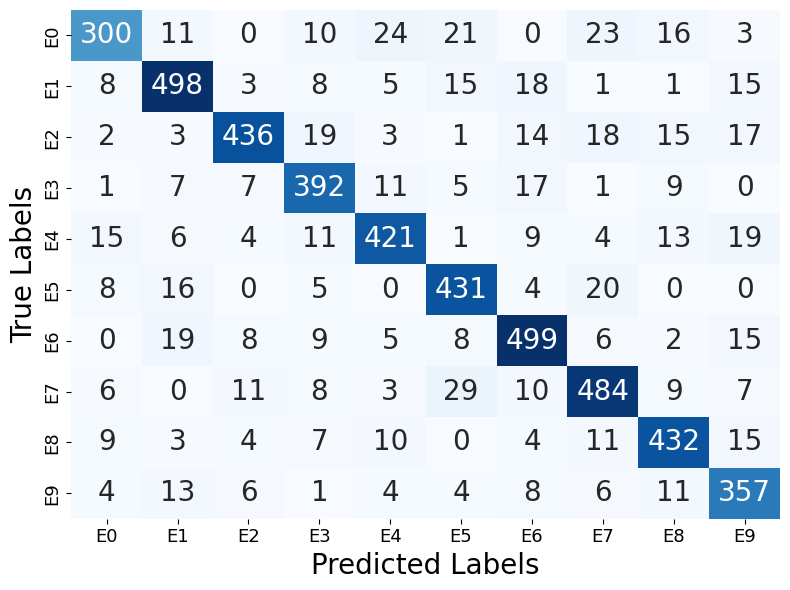

In [357]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and get predictions
Y_pred = cwru_model.predict(X_val)
Y_pred_classes = Y_pred.argmax(axis=1)  # Get the predicted class index
Y_true = Y_val_fake   # Get the true class index

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

# Define class labels (replace with your actual class names)
class_labels = [f"E{i}" for i in range (10)]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
           annot_kws={"size": 20}, cbar=False)
plt.xlabel('Predicted Labels', fontsize=20)
plt.ylabel('True Labels', fontsize=20)
#plt.title('CWRU', fontsize = 30)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.tight_layout()
plt.savefig('fake_envelope_cm_cwru.pdf')

Obtain explanation on the fake validation set:

In [355]:
from tqdm import tqdm
sample = 0

explanations = []
targets = []
indexes = np.arange(0, X_val.shape[0])
np.random.shuffle(indexes)
for sample in tqdm(indexes[:1500]):

    difflime = lime.DiffLIME(cwru_model, dpm_model, centroids, nsamples=100, verbose=False)

    _, explanation, prediction_score, local_pred, source_prob, source_klass = difflime.explain(X_val[sample])
    explanations.append(explanation)
    
    targets.append(source_klass)

    print(np.mean(np.argmax(np.array(explanations)[:, -10:], axis=1) == targets))
    print(np.mean([(9-a)[i] for a, i in zip(np.argsort(np.argsort(np.array(explanations)[:, -10:], axis=1)), 
                                                 targets)
                  ]
                 )
         )    
    

  0%|          | 1/1500 [00:00<23:59,  1.04it/s]

0.0
3.0


  0%|          | 2/1500 [00:01<22:36,  1.10it/s]

0.5
1.5


  0%|          | 3/1500 [00:02<22:33,  1.11it/s]

0.6666666666666666
1.0


  0%|          | 4/1500 [00:03<22:50,  1.09it/s]

0.75
0.75


  0%|          | 5/1500 [00:04<24:04,  1.03it/s]

0.8
0.6


  0%|          | 6/1500 [00:05<23:35,  1.06it/s]

0.8333333333333334
0.5


  0%|          | 7/1500 [00:06<24:06,  1.03it/s]

0.8571428571428571
0.42857142857142855


  1%|          | 8/1500 [00:07<24:03,  1.03it/s]

0.875
0.375


  1%|          | 9/1500 [00:08<23:19,  1.07it/s]

0.8888888888888888
0.3333333333333333


  1%|          | 10/1500 [00:09<24:23,  1.02it/s]

0.9
0.3


  1%|          | 11/1500 [00:10<23:49,  1.04it/s]

0.9090909090909091
0.2727272727272727


  1%|          | 12/1500 [00:11<23:25,  1.06it/s]

0.8333333333333334
1.0


  1%|          | 13/1500 [00:12<23:47,  1.04it/s]

0.7692307692307693
1.0


  1%|          | 14/1500 [00:13<24:08,  1.03it/s]

0.7857142857142857
0.9285714285714286


  1%|          | 15/1500 [00:14<23:28,  1.05it/s]

0.8
0.8666666666666667


  1%|          | 16/1500 [00:15<22:59,  1.08it/s]

0.75
1.375


  1%|          | 17/1500 [00:16<22:55,  1.08it/s]

0.7058823529411765
1.7058823529411764


  1%|          | 18/1500 [00:16<22:31,  1.10it/s]

0.7222222222222222
1.6111111111111112


  1%|▏         | 19/1500 [00:18<23:33,  1.05it/s]

0.7368421052631579
1.5263157894736843


  1%|▏         | 20/1500 [00:19<24:35,  1.00it/s]

0.75
1.45


  1%|▏         | 21/1500 [00:20<23:56,  1.03it/s]

0.7142857142857143
1.4285714285714286


  1%|▏         | 22/1500 [00:20<23:29,  1.05it/s]

0.6818181818181818
1.4090909090909092


  2%|▏         | 23/1500 [00:21<22:53,  1.08it/s]

0.6956521739130435
1.3478260869565217


  2%|▏         | 24/1500 [00:22<22:45,  1.08it/s]

0.6666666666666666
1.6666666666666667


  2%|▏         | 25/1500 [00:23<22:43,  1.08it/s]

0.64
1.68


  2%|▏         | 26/1500 [00:24<23:33,  1.04it/s]

0.6153846153846154
1.6923076923076923


  2%|▏         | 27/1500 [00:25<23:43,  1.03it/s]

0.5925925925925926
1.8148148148148149


  2%|▏         | 28/1500 [00:26<23:56,  1.03it/s]

0.6071428571428571
1.75


  2%|▏         | 29/1500 [00:27<24:16,  1.01it/s]

0.5862068965517241
1.896551724137931


  2%|▏         | 30/1500 [00:28<23:47,  1.03it/s]

0.5666666666666667
1.8666666666666667


  2%|▏         | 31/1500 [00:29<23:55,  1.02it/s]

0.5483870967741935
1.935483870967742


  2%|▏         | 32/1500 [00:30<24:22,  1.00it/s]

0.5625
1.875


  2%|▏         | 33/1500 [00:31<24:30,  1.00s/it]

0.5454545454545454
1.9090909090909092


  2%|▏         | 34/1500 [00:32<25:02,  1.03s/it]

0.5294117647058824
2.0294117647058822


  2%|▏         | 35/1500 [00:33<25:25,  1.04s/it]

0.5428571428571428
1.9714285714285715


  2%|▏         | 36/1500 [00:34<25:17,  1.04s/it]

0.5555555555555556
1.9166666666666667


  2%|▏         | 37/1500 [00:35<24:05,  1.01it/s]

0.5675675675675675
1.864864864864865


  3%|▎         | 38/1500 [00:36<23:30,  1.04it/s]

0.5526315789473685
1.868421052631579


  3%|▎         | 39/1500 [00:37<23:34,  1.03it/s]

0.5384615384615384
1.9487179487179487


  3%|▎         | 40/1500 [00:38<24:10,  1.01it/s]

0.525
1.925


  3%|▎         | 41/1500 [00:39<23:27,  1.04it/s]

0.5121951219512195
1.975609756097561


  3%|▎         | 42/1500 [00:40<23:07,  1.05it/s]

0.5
2.0238095238095237


  3%|▎         | 43/1500 [00:41<22:33,  1.08it/s]

0.4883720930232558
2.1627906976744184


  3%|▎         | 44/1500 [00:42<22:52,  1.06it/s]

0.5
2.1136363636363638


  3%|▎         | 45/1500 [00:43<23:50,  1.02it/s]

0.4888888888888889
2.088888888888889


  3%|▎         | 46/1500 [00:44<23:29,  1.03it/s]

0.4782608695652174
2.108695652173913


  3%|▎         | 47/1500 [00:45<22:46,  1.06it/s]

0.46808510638297873
2.2127659574468086


  3%|▎         | 48/1500 [00:46<22:18,  1.08it/s]

0.4791666666666667
2.1666666666666665


  3%|▎         | 49/1500 [00:47<22:56,  1.05it/s]

0.4897959183673469
2.122448979591837


  3%|▎         | 50/1500 [00:48<22:42,  1.06it/s]

0.48
2.1


  3%|▎         | 51/1500 [00:49<23:29,  1.03it/s]

0.49019607843137253
2.0588235294117645


  3%|▎         | 52/1500 [00:50<23:56,  1.01it/s]

0.4807692307692308
2.0384615384615383


  4%|▎         | 53/1500 [00:51<24:01,  1.00it/s]

0.49056603773584906
2.0


  4%|▎         | 54/1500 [00:52<24:05,  1.00it/s]

0.48148148148148145
2.037037037037037


  4%|▎         | 55/1500 [00:53<24:18,  1.01s/it]

0.4909090909090909
2.0


  4%|▎         | 56/1500 [00:54<23:30,  1.02it/s]

0.5
1.9642857142857142


  4%|▍         | 57/1500 [00:54<22:47,  1.06it/s]

0.49122807017543857
2.0526315789473686


  4%|▍         | 58/1500 [00:55<22:50,  1.05it/s]

0.4827586206896552
2.1724137931034484


  4%|▍         | 59/1500 [00:56<23:42,  1.01it/s]

0.4915254237288136
2.135593220338983


  4%|▍         | 60/1500 [00:57<23:21,  1.03it/s]

0.5
2.1


  4%|▍         | 61/1500 [00:58<22:38,  1.06it/s]

0.4918032786885246
2.2131147540983607


  4%|▍         | 62/1500 [00:59<23:20,  1.03it/s]

0.4838709677419355
2.193548387096774


  4%|▍         | 63/1500 [01:00<23:50,  1.00it/s]

0.47619047619047616
2.253968253968254


  4%|▍         | 64/1500 [01:01<22:58,  1.04it/s]

0.46875
2.234375


  4%|▍         | 65/1500 [01:02<22:42,  1.05it/s]

0.47692307692307695
2.2


  4%|▍         | 66/1500 [01:03<22:59,  1.04it/s]

0.4696969696969697
2.257575757575758


  4%|▍         | 67/1500 [01:04<22:23,  1.07it/s]

0.47761194029850745
2.2238805970149254


  5%|▍         | 68/1500 [01:05<22:14,  1.07it/s]

0.4852941176470588
2.1911764705882355


  5%|▍         | 69/1500 [01:06<22:04,  1.08it/s]

0.4782608695652174
2.246376811594203


  5%|▍         | 70/1500 [01:07<21:39,  1.10it/s]

0.4714285714285714
2.3285714285714287


  5%|▍         | 71/1500 [01:08<22:18,  1.07it/s]

0.4647887323943662
2.380281690140845


  5%|▍         | 72/1500 [01:09<22:47,  1.04it/s]

0.4583333333333333
2.4166666666666665


  5%|▍         | 73/1500 [01:10<23:21,  1.02it/s]

0.4657534246575342
2.3835616438356166


  5%|▍         | 74/1500 [01:11<22:44,  1.04it/s]

0.4594594594594595
2.4324324324324325


  5%|▌         | 75/1500 [01:12<22:59,  1.03it/s]

0.4533333333333333
2.4266666666666667


  5%|▌         | 76/1500 [01:13<22:29,  1.06it/s]

0.4605263157894737
2.3947368421052633


  5%|▌         | 77/1500 [01:14<23:23,  1.01it/s]

0.4675324675324675
2.3636363636363638


  5%|▌         | 78/1500 [01:15<23:32,  1.01it/s]

0.46153846153846156
2.358974358974359


  5%|▌         | 79/1500 [01:16<23:27,  1.01it/s]

0.46835443037974683
2.329113924050633


  5%|▌         | 80/1500 [01:17<23:27,  1.01it/s]

0.4625
2.35


  5%|▌         | 81/1500 [01:18<23:43,  1.00s/it]

0.4567901234567901
2.345679012345679


  5%|▌         | 82/1500 [01:19<24:01,  1.02s/it]

0.45121951219512196
2.3292682926829267


  6%|▌         | 83/1500 [01:20<23:09,  1.02it/s]

0.4578313253012048
2.3012048192771086


  6%|▌         | 84/1500 [01:21<23:09,  1.02it/s]

0.4642857142857143
2.2738095238095237


  6%|▌         | 85/1500 [01:22<23:51,  1.01s/it]

0.47058823529411764
2.2470588235294118


  6%|▌         | 86/1500 [01:23<23:51,  1.01s/it]

0.47674418604651164
2.2209302325581395


  6%|▌         | 87/1500 [01:24<23:23,  1.01it/s]

0.4827586206896552
2.1954022988505746


  6%|▌         | 88/1500 [01:25<23:34,  1.00s/it]

0.4772727272727273
2.1818181818181817


  6%|▌         | 89/1500 [01:26<22:53,  1.03it/s]

0.47191011235955055
2.191011235955056


  6%|▌         | 90/1500 [01:27<22:32,  1.04it/s]

0.4666666666666667
2.2555555555555555


  6%|▌         | 91/1500 [01:28<22:56,  1.02it/s]

0.4725274725274725
2.230769230769231


  6%|▌         | 92/1500 [01:28<22:28,  1.04it/s]

0.4673913043478261
2.2934782608695654


  6%|▌         | 93/1500 [01:29<22:52,  1.03it/s]

0.46236559139784944
2.3655913978494625


  6%|▋         | 94/1500 [01:31<23:41,  1.01s/it]

0.4574468085106383
2.382978723404255


  6%|▋         | 95/1500 [01:32<23:14,  1.01it/s]

0.4631578947368421
2.357894736842105


  6%|▋         | 96/1500 [01:33<23:51,  1.02s/it]

0.4583333333333333
2.40625


  6%|▋         | 97/1500 [01:34<23:44,  1.02s/it]

0.4536082474226804
2.4536082474226806


  7%|▋         | 98/1500 [01:34<22:35,  1.03it/s]

0.45918367346938777
2.4285714285714284


  7%|▋         | 99/1500 [01:35<21:55,  1.07it/s]

0.46464646464646464
2.404040404040404


  7%|▋         | 100/1500 [01:36<21:30,  1.09it/s]

0.47
2.38


  7%|▋         | 101/1500 [01:37<22:10,  1.05it/s]

0.46534653465346537
2.4257425742574257


  7%|▋         | 102/1500 [01:38<21:55,  1.06it/s]

0.47058823529411764
2.4019607843137254


  7%|▋         | 103/1500 [01:39<22:23,  1.04it/s]

0.47572815533980584
2.378640776699029


  7%|▋         | 104/1500 [01:40<22:54,  1.02it/s]

0.47115384615384615
2.3653846153846154


  7%|▋         | 105/1500 [01:41<22:26,  1.04it/s]

0.4666666666666667
2.4


  7%|▋         | 106/1500 [01:42<21:54,  1.06it/s]

0.46226415094339623
2.3867924528301887


  7%|▋         | 107/1500 [01:43<22:35,  1.03it/s]

0.4672897196261682
2.364485981308411


  7%|▋         | 108/1500 [01:44<22:58,  1.01it/s]

0.46296296296296297
2.4166666666666665


  7%|▋         | 109/1500 [01:45<22:26,  1.03it/s]

0.45871559633027525
2.467889908256881


  7%|▋         | 110/1500 [01:46<22:08,  1.05it/s]

0.45454545454545453
2.4727272727272727


  7%|▋         | 111/1500 [01:47<21:54,  1.06it/s]

0.4594594594594595
2.4504504504504503


  7%|▋         | 112/1500 [01:48<21:41,  1.07it/s]

0.45535714285714285
2.4642857142857144


  8%|▊         | 113/1500 [01:49<21:18,  1.08it/s]

0.46017699115044247
2.4424778761061945


  8%|▊         | 114/1500 [01:50<21:03,  1.10it/s]

0.4649122807017544
2.4210526315789473


  8%|▊         | 115/1500 [01:51<22:23,  1.03it/s]

0.4608695652173913
2.4695652173913043


  8%|▊         | 116/1500 [01:52<22:52,  1.01it/s]

0.45689655172413796
2.5086206896551726


  8%|▊         | 117/1500 [01:53<23:20,  1.01s/it]

0.46153846153846156
2.4871794871794872


  8%|▊         | 118/1500 [01:54<22:37,  1.02it/s]

0.4576271186440678
2.5338983050847457


  8%|▊         | 119/1500 [01:55<22:10,  1.04it/s]

0.453781512605042
2.563025210084034


  8%|▊         | 120/1500 [01:55<21:36,  1.06it/s]

0.45
2.6083333333333334


  8%|▊         | 121/1500 [01:57<22:33,  1.02it/s]

0.45454545454545453
2.5867768595041323


  8%|▊         | 122/1500 [01:57<22:02,  1.04it/s]

0.45901639344262296
2.5655737704918034


  8%|▊         | 123/1500 [01:59<23:01,  1.00s/it]

0.4634146341463415
2.5447154471544717


  8%|▊         | 124/1500 [01:59<22:23,  1.02it/s]

0.4596774193548387
2.5725806451612905


  8%|▊         | 125/1500 [02:01<22:51,  1.00it/s]

0.456
2.624


  8%|▊         | 126/1500 [02:02<23:02,  1.01s/it]

0.4603174603174603
2.6031746031746033


  8%|▊         | 127/1500 [02:03<22:49,  1.00it/s]

0.4566929133858268
2.622047244094488


  9%|▊         | 128/1500 [02:04<22:51,  1.00it/s]

0.4609375
2.6015625


  9%|▊         | 129/1500 [02:04<21:55,  1.04it/s]

0.4573643410852713
2.5968992248062017


  9%|▊         | 130/1500 [02:05<22:12,  1.03it/s]

0.46153846153846156
2.576923076923077


  9%|▊         | 131/1500 [02:06<21:37,  1.05it/s]

0.4580152671755725
2.5877862595419847


  9%|▉         | 132/1500 [02:07<22:16,  1.02it/s]

0.45454545454545453
2.606060606060606


  9%|▉         | 133/1500 [02:08<22:34,  1.01it/s]

0.45112781954887216
2.654135338345865


  9%|▉         | 134/1500 [02:09<22:54,  1.01s/it]

0.4552238805970149
2.6343283582089554


  9%|▉         | 135/1500 [02:10<23:15,  1.02s/it]

0.45185185185185184
2.637037037037037


  9%|▉         | 136/1500 [02:11<23:16,  1.02s/it]

0.45588235294117646
2.6176470588235294


  9%|▉         | 137/1500 [02:13<23:23,  1.03s/it]

0.45985401459854014
2.5985401459854014


  9%|▉         | 138/1500 [02:13<22:31,  1.01it/s]

0.45652173913043476
2.601449275362319


  9%|▉         | 139/1500 [02:14<21:36,  1.05it/s]

0.45323741007194246
2.597122302158273


  9%|▉         | 140/1500 [02:15<20:56,  1.08it/s]

0.45
2.642857142857143


  9%|▉         | 141/1500 [02:16<21:40,  1.05it/s]

0.44680851063829785
2.645390070921986


  9%|▉         | 142/1500 [02:17<20:54,  1.08it/s]

0.4507042253521127
2.6267605633802815


 10%|▉         | 143/1500 [02:18<20:29,  1.10it/s]

0.44755244755244755
2.664335664335664


 10%|▉         | 144/1500 [02:19<21:40,  1.04it/s]

0.4513888888888889
2.6458333333333335


 10%|▉         | 145/1500 [02:20<21:16,  1.06it/s]

0.45517241379310347
2.627586206896552


 10%|▉         | 146/1500 [02:21<21:42,  1.04it/s]

0.4520547945205479
2.636986301369863


 10%|▉         | 147/1500 [02:22<21:13,  1.06it/s]

0.4489795918367347
2.6598639455782314


 10%|▉         | 148/1500 [02:23<21:48,  1.03it/s]

0.44594594594594594
2.6486486486486487


 10%|▉         | 149/1500 [02:24<21:27,  1.05it/s]

0.4429530201342282
2.6577181208053693


 10%|█         | 150/1500 [02:25<21:46,  1.03it/s]

0.44
2.6533333333333333


 10%|█         | 151/1500 [02:26<21:15,  1.06it/s]

0.44370860927152317
2.6357615894039736


 10%|█         | 152/1500 [02:26<20:46,  1.08it/s]

0.4407894736842105
2.6776315789473686


 10%|█         | 153/1500 [02:27<20:23,  1.10it/s]

0.43790849673202614
2.6993464052287583


 10%|█         | 154/1500 [02:28<20:06,  1.12it/s]

0.44155844155844154
2.6818181818181817


 10%|█         | 155/1500 [02:29<21:03,  1.06it/s]

0.43870967741935485
2.696774193548387


 10%|█         | 156/1500 [02:30<21:00,  1.07it/s]

0.4358974358974359
2.7115384615384617


 10%|█         | 157/1500 [02:31<20:36,  1.09it/s]

0.43312101910828027
2.751592356687898


 11%|█         | 158/1500 [02:32<20:12,  1.11it/s]

0.43670886075949367
2.7341772151898733


 11%|█         | 159/1500 [02:33<20:58,  1.07it/s]

0.4339622641509434
2.7547169811320753


 11%|█         | 160/1500 [02:34<21:02,  1.06it/s]

0.4375
2.7375


 11%|█         | 161/1500 [02:35<20:33,  1.09it/s]

0.43478260869565216
2.732919254658385


 11%|█         | 162/1500 [02:36<21:06,  1.06it/s]

0.43209876543209874
2.765432098765432


 11%|█         | 163/1500 [02:37<20:56,  1.06it/s]

0.4294478527607362
2.754601226993865


 11%|█         | 164/1500 [02:38<21:11,  1.05it/s]

0.4268292682926829
2.7621951219512195


 11%|█         | 165/1500 [02:39<20:37,  1.08it/s]

0.4303030303030303
2.7454545454545456


 11%|█         | 166/1500 [02:40<21:34,  1.03it/s]

0.42771084337349397
2.7710843373493974


 11%|█         | 167/1500 [02:41<21:14,  1.05it/s]

0.4251497005988024
2.7604790419161676


 11%|█         | 168/1500 [02:41<20:39,  1.07it/s]

0.4226190476190476
2.761904761904762


 11%|█▏        | 169/1500 [02:42<21:12,  1.05it/s]

0.4260355029585799
2.7455621301775146


 11%|█▏        | 170/1500 [02:43<21:38,  1.02it/s]

0.4235294117647059
2.735294117647059


 11%|█▏        | 171/1500 [02:45<22:00,  1.01it/s]

0.42105263157894735
2.742690058479532


 11%|█▏        | 172/1500 [02:45<21:15,  1.04it/s]

0.4186046511627907
2.7674418604651163


 12%|█▏        | 173/1500 [02:46<20:42,  1.07it/s]

0.42196531791907516
2.7514450867052025


 12%|█▏        | 174/1500 [02:47<20:34,  1.07it/s]

0.42528735632183906
2.735632183908046


 12%|█▏        | 175/1500 [02:48<21:11,  1.04it/s]

0.42857142857142855
2.72


 12%|█▏        | 176/1500 [02:49<21:55,  1.01it/s]

0.42613636363636365
2.75


 12%|█▏        | 177/1500 [02:50<22:07,  1.00s/it]

0.423728813559322
2.7457627118644066


 12%|█▏        | 178/1500 [02:51<21:29,  1.02it/s]

0.42696629213483145
2.730337078651685


 12%|█▏        | 179/1500 [02:52<21:35,  1.02it/s]

0.4245810055865922
2.7541899441340782


 12%|█▏        | 180/1500 [02:53<22:27,  1.02s/it]

0.4222222222222222
2.7888888888888888


 12%|█▏        | 181/1500 [02:54<21:29,  1.02it/s]

0.425414364640884
2.773480662983425


 12%|█▏        | 182/1500 [02:55<21:41,  1.01it/s]

0.4230769230769231
2.791208791208791


 12%|█▏        | 183/1500 [02:56<21:04,  1.04it/s]

0.4207650273224044
2.7923497267759565


 12%|█▏        | 184/1500 [02:57<20:28,  1.07it/s]

0.42391304347826086
2.777173913043478


 12%|█▏        | 185/1500 [02:58<20:04,  1.09it/s]

0.42162162162162165
2.7837837837837838


 12%|█▏        | 186/1500 [02:59<20:45,  1.06it/s]

0.41935483870967744
2.774193548387097


 12%|█▏        | 187/1500 [03:00<21:35,  1.01it/s]

0.41711229946524064
2.786096256684492


 13%|█▎        | 188/1500 [03:01<21:58,  1.01s/it]

0.42021276595744683
2.771276595744681


 13%|█▎        | 189/1500 [03:02<21:16,  1.03it/s]

0.42328042328042326
2.7566137566137567


 13%|█▎        | 190/1500 [03:03<21:25,  1.02it/s]

0.42105263157894735
2.7473684210526317


 13%|█▎        | 191/1500 [03:04<21:50,  1.00s/it]

0.418848167539267
2.743455497382199


 13%|█▎        | 192/1500 [03:05<21:09,  1.03it/s]

0.4166666666666667
2.734375


 13%|█▎        | 193/1500 [03:06<20:28,  1.06it/s]

0.41450777202072536
2.7512953367875648


 13%|█▎        | 194/1500 [03:07<19:59,  1.09it/s]

0.4175257731958763
2.7371134020618557


 13%|█▎        | 195/1500 [03:07<19:55,  1.09it/s]

0.4153846153846154
2.7384615384615385


 13%|█▎        | 196/1500 [03:08<19:35,  1.11it/s]

0.41836734693877553
2.7244897959183674


 13%|█▎        | 197/1500 [03:09<20:41,  1.05it/s]

0.41624365482233505
2.720812182741117


 13%|█▎        | 198/1500 [03:10<21:02,  1.03it/s]

0.41414141414141414
2.7525252525252526


 13%|█▎        | 199/1500 [03:11<21:20,  1.02it/s]

0.4120603015075377
2.758793969849246


 13%|█▎        | 200/1500 [03:12<21:38,  1.00it/s]

0.41
2.77


 13%|█▎        | 201/1500 [03:13<20:51,  1.04it/s]

0.4079601990049751
2.800995024875622


 13%|█▎        | 202/1500 [03:14<20:14,  1.07it/s]

0.41089108910891087
2.787128712871287


 14%|█▎        | 203/1500 [03:15<19:54,  1.09it/s]

0.4088669950738916
2.7881773399014778


 14%|█▎        | 204/1500 [03:16<20:18,  1.06it/s]

0.4117647058823529
2.7745098039215685


 14%|█▎        | 205/1500 [03:17<20:14,  1.07it/s]

0.4097560975609756
2.765853658536585


 14%|█▎        | 206/1500 [03:18<21:29,  1.00it/s]

0.4077669902912621
2.7864077669902914


 14%|█▍        | 207/1500 [03:19<21:53,  1.02s/it]

0.4057971014492754
2.8067632850241546


 14%|█▍        | 208/1500 [03:20<21:05,  1.02it/s]

0.40384615384615385
2.798076923076923


 14%|█▍        | 209/1500 [03:21<21:30,  1.00it/s]

0.4019138755980861
2.789473684210526


 14%|█▍        | 210/1500 [03:22<21:39,  1.01s/it]

0.40476190476190477
2.776190476190476


 14%|█▍        | 211/1500 [03:23<21:47,  1.01s/it]

0.4028436018957346
2.7819905213270144


 14%|█▍        | 212/1500 [03:24<21:55,  1.02s/it]

0.4009433962264151
2.7783018867924527


 14%|█▍        | 213/1500 [03:25<21:06,  1.02it/s]

0.40375586854460094
2.7652582159624415


 14%|█▍        | 214/1500 [03:26<20:38,  1.04it/s]

0.40186915887850466
2.7710280373831777


 14%|█▍        | 215/1500 [03:27<20:06,  1.06it/s]

0.4046511627906977
2.7581395348837208


 14%|█▍        | 216/1500 [03:28<19:38,  1.09it/s]

0.4027777777777778
2.75


 14%|█▍        | 217/1500 [03:29<20:21,  1.05it/s]

0.4055299539170507
2.737327188940092


 15%|█▍        | 218/1500 [03:30<21:12,  1.01it/s]

0.4036697247706422
2.7477064220183487


 15%|█▍        | 219/1500 [03:31<21:21,  1.00s/it]

0.4018264840182648
2.73972602739726


 15%|█▍        | 220/1500 [03:32<21:42,  1.02s/it]

0.40454545454545454
2.727272727272727


 15%|█▍        | 221/1500 [03:33<21:39,  1.02s/it]

0.40271493212669685
2.728506787330317


 15%|█▍        | 222/1500 [03:34<20:44,  1.03it/s]

0.40540540540540543
2.7162162162162162


 15%|█▍        | 223/1500 [03:35<20:19,  1.05it/s]

0.40358744394618834
2.713004484304933


 15%|█▍        | 224/1500 [03:36<20:34,  1.03it/s]

0.4017857142857143
2.7232142857142856


 15%|█▌        | 225/1500 [03:37<19:56,  1.07it/s]

0.40444444444444444
2.7111111111111112


 15%|█▌        | 226/1500 [03:38<20:45,  1.02it/s]

0.40707964601769914
2.6991150442477876


 15%|█▌        | 227/1500 [03:39<20:58,  1.01it/s]

0.4052863436123348
2.7136563876651985


 15%|█▌        | 228/1500 [03:40<21:04,  1.01it/s]

0.40350877192982454
2.710526315789474


 15%|█▌        | 229/1500 [03:41<21:34,  1.02s/it]

0.4017467248908297
2.7117903930131004


 15%|█▌        | 230/1500 [03:42<21:47,  1.03s/it]

0.4043478260869565
2.7


 15%|█▌        | 231/1500 [03:43<21:50,  1.03s/it]

0.4025974025974026
2.722943722943723


 15%|█▌        | 232/1500 [03:44<21:53,  1.04s/it]

0.40086206896551724
2.7370689655172415


 16%|█▌        | 233/1500 [03:45<21:37,  1.02s/it]

0.39914163090128757
2.7339055793991416


 16%|█▌        | 234/1500 [03:46<20:37,  1.02it/s]

0.4017094017094017
2.7222222222222223


 16%|█▌        | 235/1500 [03:47<21:06,  1.00s/it]

0.40425531914893614
2.7106382978723405


 16%|█▌        | 236/1500 [03:48<21:16,  1.01s/it]

0.4067796610169492
2.6991525423728815


 16%|█▌        | 237/1500 [03:49<21:14,  1.01s/it]

0.4050632911392405
2.691983122362869


 16%|█▌        | 238/1500 [03:50<20:47,  1.01it/s]

0.40336134453781514
2.7016806722689077


 16%|█▌        | 239/1500 [03:51<21:01,  1.00s/it]

0.401673640167364
2.702928870292887


 16%|█▌        | 240/1500 [03:52<20:12,  1.04it/s]

0.4
2.7


 16%|█▌        | 241/1500 [03:53<19:37,  1.07it/s]

0.4024896265560166
2.6887966804979255


 16%|█▌        | 242/1500 [03:54<19:47,  1.06it/s]

0.4049586776859504
2.677685950413223


 16%|█▌        | 243/1500 [03:55<20:00,  1.05it/s]

0.4074074074074074
2.6666666666666665


 16%|█▋        | 244/1500 [03:56<19:32,  1.07it/s]

0.4057377049180328
2.6844262295081966


 16%|█▋        | 245/1500 [03:56<19:28,  1.07it/s]

0.40408163265306124
2.706122448979592


 16%|█▋        | 246/1500 [03:57<19:07,  1.09it/s]

0.4024390243902439
2.731707317073171


 16%|█▋        | 247/1500 [03:58<19:21,  1.08it/s]

0.4008097165991903
2.757085020242915


 17%|█▋        | 248/1500 [03:59<19:03,  1.09it/s]

0.39919354838709675
2.7701612903225805


 17%|█▋        | 249/1500 [04:00<20:09,  1.03it/s]

0.40160642570281124
2.7590361445783134


 17%|█▋        | 250/1500 [04:01<19:34,  1.06it/s]

0.4
2.768


 17%|█▋        | 251/1500 [04:02<20:05,  1.04it/s]

0.40239043824701193
2.756972111553785


 17%|█▋        | 252/1500 [04:03<20:17,  1.02it/s]

0.40476190476190477
2.746031746031746


 17%|█▋        | 253/1500 [04:04<20:33,  1.01it/s]

0.4031620553359684
2.7707509881422925


 17%|█▋        | 254/1500 [04:05<19:46,  1.05it/s]

0.40551181102362205
2.7598425196850394


 17%|█▋        | 255/1500 [04:06<19:13,  1.08it/s]

0.403921568627451
2.7529411764705882


 17%|█▋        | 256/1500 [04:07<19:44,  1.05it/s]

0.40625
2.7421875


 17%|█▋        | 257/1500 [04:08<20:29,  1.01it/s]

0.4046692607003891
2.7431906614785992


 17%|█▋        | 258/1500 [04:09<20:50,  1.01s/it]

0.40310077519379844
2.75968992248062


 17%|█▋        | 259/1500 [04:10<19:55,  1.04it/s]

0.40540540540540543
2.749034749034749


 17%|█▋        | 260/1500 [04:11<19:37,  1.05it/s]

0.40384615384615385
2.769230769230769


 17%|█▋        | 261/1500 [04:12<20:11,  1.02it/s]

0.40229885057471265
2.7662835249042144


 17%|█▋        | 262/1500 [04:13<20:08,  1.02it/s]

0.40076335877862596
2.7595419847328246


 18%|█▊        | 263/1500 [04:14<19:25,  1.06it/s]

0.40304182509505704
2.7490494296577945


 18%|█▊        | 264/1500 [04:15<19:37,  1.05it/s]

0.4015151515151515
2.742424242424242


 18%|█▊        | 265/1500 [04:16<19:59,  1.03it/s]

0.4
2.7358490566037736


 18%|█▊        | 266/1500 [04:17<20:29,  1.00it/s]

0.39849624060150374
2.7293233082706765


 18%|█▊        | 267/1500 [04:18<19:54,  1.03it/s]

0.40074906367041196
2.7191011235955056


 18%|█▊        | 268/1500 [04:19<19:18,  1.06it/s]

0.39925373134328357
2.7276119402985075


 18%|█▊        | 269/1500 [04:20<19:41,  1.04it/s]

0.39776951672862454
2.7360594795539033


 18%|█▊        | 270/1500 [04:21<20:02,  1.02it/s]

0.3962962962962963
2.759259259259259


 18%|█▊        | 271/1500 [04:21<19:48,  1.03it/s]

0.3948339483394834
2.7601476014760147


 18%|█▊        | 272/1500 [04:22<20:03,  1.02it/s]

0.39338235294117646
2.7573529411764706


 18%|█▊        | 273/1500 [04:24<20:36,  1.01s/it]

0.39194139194139194
2.7545787545787546


 18%|█▊        | 274/1500 [04:24<19:45,  1.03it/s]

0.39416058394160586
2.7445255474452557


 18%|█▊        | 275/1500 [04:26<20:22,  1.00it/s]

0.39636363636363636
2.7345454545454544


 18%|█▊        | 276/1500 [04:26<19:47,  1.03it/s]

0.39492753623188404
2.753623188405797


 18%|█▊        | 277/1500 [04:27<19:26,  1.05it/s]

0.3935018050541516
2.7725631768953067


 19%|█▊        | 278/1500 [04:28<18:57,  1.07it/s]

0.39568345323741005
2.762589928057554


 19%|█▊        | 279/1500 [04:29<19:21,  1.05it/s]

0.3978494623655914
2.752688172043011


 19%|█▊        | 280/1500 [04:30<19:37,  1.04it/s]

0.4
2.742857142857143


 19%|█▊        | 281/1500 [04:31<19:30,  1.04it/s]

0.398576512455516
2.7402135231316724


 19%|█▉        | 282/1500 [04:32<19:54,  1.02it/s]

0.40070921985815605
2.730496453900709


 19%|█▉        | 283/1500 [04:33<19:52,  1.02it/s]

0.3992932862190813
2.724381625441696


 19%|█▉        | 284/1500 [04:34<19:56,  1.02it/s]

0.4014084507042254
2.714788732394366


 19%|█▉        | 285/1500 [04:35<19:22,  1.05it/s]

0.40350877192982454
2.705263157894737


 19%|█▉        | 286/1500 [04:36<19:26,  1.04it/s]

0.40559440559440557
2.695804195804196


 19%|█▉        | 287/1500 [04:37<18:54,  1.07it/s]

0.40418118466898956
2.6898954703832754


 19%|█▉        | 288/1500 [04:38<19:25,  1.04it/s]

0.4027777777777778
2.6840277777777777


 19%|█▉        | 289/1500 [04:39<19:41,  1.03it/s]

0.4013840830449827
2.698961937716263


 19%|█▉        | 290/1500 [04:40<19:11,  1.05it/s]

0.4
2.693103448275862


 19%|█▉        | 291/1500 [04:41<19:40,  1.02it/s]

0.4020618556701031
2.683848797250859


 19%|█▉        | 292/1500 [04:42<19:09,  1.05it/s]

0.4006849315068493
2.684931506849315


 20%|█▉        | 293/1500 [04:43<19:34,  1.03it/s]

0.3993174061433447
2.6860068259385668


 20%|█▉        | 294/1500 [04:44<19:54,  1.01it/s]

0.4013605442176871
2.67687074829932


 20%|█▉        | 295/1500 [04:45<19:45,  1.02it/s]

0.4033898305084746
2.6677966101694914


 20%|█▉        | 296/1500 [04:46<19:06,  1.05it/s]

0.40202702702702703
2.6722972972972974


 20%|█▉        | 297/1500 [04:47<18:37,  1.08it/s]

0.4006734006734007
2.6835016835016834


 20%|█▉        | 298/1500 [04:47<18:17,  1.09it/s]

0.40268456375838924
2.674496644295302


 20%|█▉        | 299/1500 [04:48<18:04,  1.11it/s]

0.40468227424749165
2.6655518394648827


 20%|██        | 300/1500 [04:49<19:02,  1.05it/s]

0.4033333333333333
2.683333333333333


 20%|██        | 301/1500 [04:50<19:36,  1.02it/s]

0.4019933554817276
2.6877076411960132


 20%|██        | 302/1500 [04:51<20:07,  1.01s/it]

0.40397350993377484
2.6788079470198674


 20%|██        | 303/1500 [04:52<20:10,  1.01s/it]

0.40594059405940597
2.66996699669967


 20%|██        | 304/1500 [04:53<20:07,  1.01s/it]

0.40789473684210525
2.661184210526316


 20%|██        | 305/1500 [04:54<19:28,  1.02it/s]

0.4065573770491803
2.6557377049180326


 20%|██        | 306/1500 [04:55<19:36,  1.01it/s]

0.40522875816993464
2.65359477124183


 20%|██        | 307/1500 [04:56<19:06,  1.04it/s]

0.40390879478827363
2.6742671009771986


 21%|██        | 308/1500 [04:57<19:27,  1.02it/s]

0.40584415584415584
2.6655844155844157


 21%|██        | 309/1500 [04:58<19:44,  1.01it/s]

0.4077669902912621
2.656957928802589


 21%|██        | 310/1500 [04:59<19:47,  1.00it/s]

0.4096774193548387
2.6483870967741936


 21%|██        | 311/1500 [05:00<19:57,  1.01s/it]

0.40836012861736337
2.6591639871382635


 21%|██        | 312/1500 [05:01<20:02,  1.01s/it]

0.40705128205128205
2.657051282051282


 21%|██        | 313/1500 [05:02<19:58,  1.01s/it]

0.4057507987220447
2.6741214057507987


 21%|██        | 314/1500 [05:03<20:02,  1.01s/it]

0.40764331210191085
2.6656050955414012


 21%|██        | 315/1500 [05:04<20:09,  1.02s/it]

0.40634920634920635
2.6857142857142855


 21%|██        | 316/1500 [05:06<20:09,  1.02s/it]

0.4050632911392405
2.7056962025316458


 21%|██        | 317/1500 [05:07<20:08,  1.02s/it]

0.4069400630914827
2.697160883280757


 21%|██        | 318/1500 [05:07<19:12,  1.03it/s]

0.4088050314465409
2.688679245283019


 21%|██▏       | 319/1500 [05:08<18:55,  1.04it/s]

0.4106583072100313
2.6802507836990594


 21%|██▏       | 320/1500 [05:09<19:15,  1.02it/s]

0.409375
2.690625


 21%|██▏       | 321/1500 [05:10<19:38,  1.00it/s]

0.40809968847352024
2.6853582554517135


 21%|██▏       | 322/1500 [05:11<19:48,  1.01s/it]

0.40993788819875776
2.6770186335403725


 22%|██▏       | 323/1500 [05:12<19:52,  1.01s/it]

0.4086687306501548
2.681114551083591


 22%|██▏       | 324/1500 [05:13<18:56,  1.03it/s]

0.4074074074074074
2.6882716049382718


 22%|██▏       | 325/1500 [05:14<18:19,  1.07it/s]

0.40615384615384614
2.6984615384615385


 22%|██▏       | 326/1500 [05:15<19:07,  1.02it/s]

0.4049079754601227
2.7177914110429446


 22%|██▏       | 327/1500 [05:16<19:27,  1.00it/s]

0.4036697247706422
2.7339449541284404


 22%|██▏       | 328/1500 [05:17<19:27,  1.00it/s]

0.4054878048780488
2.725609756097561


 22%|██▏       | 329/1500 [05:18<18:42,  1.04it/s]

0.4072948328267477
2.717325227963526


 22%|██▏       | 330/1500 [05:19<19:05,  1.02it/s]

0.4090909090909091
2.709090909090909


 22%|██▏       | 331/1500 [05:20<18:19,  1.06it/s]

0.4108761329305136
2.700906344410876


 22%|██▏       | 332/1500 [05:21<18:27,  1.05it/s]

0.4126506024096386
2.6927710843373496


 22%|██▏       | 333/1500 [05:22<18:47,  1.03it/s]

0.4114114114114114
2.7027027027027026


 22%|██▏       | 334/1500 [05:23<18:27,  1.05it/s]

0.4101796407185629
2.718562874251497


 22%|██▏       | 335/1500 [05:24<18:10,  1.07it/s]

0.41194029850746267
2.71044776119403


 22%|██▏       | 336/1500 [05:25<18:10,  1.07it/s]

0.41369047619047616
2.7023809523809526


 22%|██▏       | 337/1500 [05:26<18:28,  1.05it/s]

0.41543026706231456
2.6943620178041545


 23%|██▎       | 338/1500 [05:27<18:11,  1.06it/s]

0.41420118343195267
2.698224852071006


 23%|██▎       | 339/1500 [05:28<18:34,  1.04it/s]

0.41297935103244837
2.7109144542772863


 23%|██▎       | 340/1500 [05:29<18:59,  1.02it/s]

0.4147058823529412
2.7029411764705884


 23%|██▎       | 341/1500 [05:30<18:53,  1.02it/s]

0.41642228739002934
2.695014662756598


 23%|██▎       | 342/1500 [05:31<18:27,  1.05it/s]

0.4152046783625731
2.695906432748538


 23%|██▎       | 343/1500 [05:31<17:58,  1.07it/s]

0.4139941690962099
2.693877551020408


 23%|██▎       | 344/1500 [05:32<17:50,  1.08it/s]

0.4127906976744186
2.691860465116279


 23%|██▎       | 345/1500 [05:33<18:18,  1.05it/s]

0.4144927536231884
2.684057971014493


 23%|██▎       | 346/1500 [05:34<18:05,  1.06it/s]

0.41329479768786126
2.679190751445087


 23%|██▎       | 347/1500 [05:35<18:34,  1.03it/s]

0.41210374639769454
2.6887608069164264


 23%|██▎       | 348/1500 [05:36<18:51,  1.02it/s]

0.41379310344827586
2.6810344827586206


 23%|██▎       | 349/1500 [05:37<18:28,  1.04it/s]

0.41260744985673353
2.69054441260745


 23%|██▎       | 350/1500 [05:38<18:55,  1.01it/s]

0.4114285714285714
2.702857142857143


 23%|██▎       | 351/1500 [05:39<18:29,  1.04it/s]

0.4131054131054131
2.695156695156695


 23%|██▎       | 352/1500 [05:40<18:55,  1.01it/s]

0.4119318181818182
2.7073863636363638


 24%|██▎       | 353/1500 [05:41<19:09,  1.00s/it]

0.41359773371104813
2.6997167138810196


 24%|██▎       | 354/1500 [05:42<19:23,  1.02s/it]

0.4124293785310734
2.7175141242937855


 24%|██▎       | 355/1500 [05:43<19:44,  1.03s/it]

0.4140845070422535
2.7098591549295774


 24%|██▎       | 356/1500 [05:44<19:43,  1.03s/it]

0.41292134831460675
2.710674157303371


 24%|██▍       | 357/1500 [05:45<18:53,  1.01it/s]

0.41456582633053224
2.7030812324929974


 24%|██▍       | 358/1500 [05:46<19:06,  1.00s/it]

0.4134078212290503
2.712290502793296


 24%|██▍       | 359/1500 [05:47<18:22,  1.03it/s]

0.41225626740947074
2.7103064066852367


 24%|██▍       | 360/1500 [05:48<18:41,  1.02it/s]

0.4111111111111111
2.7194444444444446


 24%|██▍       | 361/1500 [05:49<18:21,  1.03it/s]

0.4099722991689751
2.736842105263158


 24%|██▍       | 362/1500 [05:50<17:52,  1.06it/s]

0.4088397790055249
2.7320441988950277


 24%|██▍       | 363/1500 [05:51<18:39,  1.02it/s]

0.41046831955922863
2.724517906336088


 24%|██▍       | 364/1500 [05:52<18:13,  1.04it/s]

0.40934065934065933
2.730769230769231


 24%|██▍       | 365/1500 [05:53<17:44,  1.07it/s]

0.410958904109589
2.723287671232877


 24%|██▍       | 366/1500 [05:54<18:12,  1.04it/s]

0.4098360655737705
2.7240437158469946


 24%|██▍       | 367/1500 [05:55<18:50,  1.00it/s]

0.4087193460490463
2.7275204359673024


 25%|██▍       | 368/1500 [05:56<18:19,  1.03it/s]

0.4076086956521739
2.744565217391304


 25%|██▍       | 369/1500 [05:57<17:55,  1.05it/s]

0.4092140921409214
2.7371273712737128


 25%|██▍       | 370/1500 [05:58<17:34,  1.07it/s]

0.41081081081081083
2.72972972972973


 25%|██▍       | 371/1500 [05:59<17:22,  1.08it/s]

0.4123989218328841
2.7223719676549867


 25%|██▍       | 372/1500 [06:00<18:21,  1.02it/s]

0.41397849462365593
2.71505376344086


 25%|██▍       | 373/1500 [06:01<18:49,  1.00s/it]

0.4128686327077748
2.721179624664879


 25%|██▍       | 374/1500 [06:02<18:59,  1.01s/it]

0.4117647058823529
2.7192513368983957


 25%|██▌       | 375/1500 [06:03<18:58,  1.01s/it]

0.4106666666666667
2.7146666666666666


 25%|██▌       | 376/1500 [06:04<18:14,  1.03it/s]

0.4095744680851064
2.7154255319148937


 25%|██▌       | 377/1500 [06:05<17:45,  1.05it/s]

0.40848806366047746
2.7320954907161803


 25%|██▌       | 378/1500 [06:06<17:25,  1.07it/s]

0.4074074074074074
2.748677248677249


 25%|██▌       | 379/1500 [06:07<18:13,  1.02it/s]

0.40633245382585753
2.762532981530343


 25%|██▌       | 380/1500 [06:08<18:28,  1.01it/s]

0.40789473684210525
2.7552631578947366


 25%|██▌       | 381/1500 [06:09<18:29,  1.01it/s]

0.4068241469816273
2.7506561679790025


 25%|██▌       | 382/1500 [06:09<17:46,  1.05it/s]

0.40575916230366493
2.7460732984293195


 26%|██▌       | 383/1500 [06:10<17:57,  1.04it/s]

0.4046997389033943
2.744125326370757


 26%|██▌       | 384/1500 [06:11<17:22,  1.07it/s]

0.4036458333333333
2.7473958333333335


 26%|██▌       | 385/1500 [06:12<16:58,  1.09it/s]

0.4051948051948052
2.74025974025974


 26%|██▌       | 386/1500 [06:13<17:11,  1.08it/s]

0.40414507772020725
2.7538860103626943


 26%|██▌       | 387/1500 [06:14<17:33,  1.06it/s]

0.40310077519379844
2.7700258397932815


 26%|██▌       | 388/1500 [06:15<17:52,  1.04it/s]

0.4020618556701031
2.7757731958762886


 26%|██▌       | 389/1500 [06:16<18:02,  1.03it/s]

0.40359897172236503
2.7686375321336762


 26%|██▌       | 390/1500 [06:17<18:21,  1.01it/s]

0.4025641025641026
2.776923076923077


 26%|██▌       | 391/1500 [06:18<18:34,  1.00s/it]

0.40153452685422
2.7774936061381075


 26%|██▌       | 392/1500 [06:19<18:40,  1.01s/it]

0.4005102040816326
2.7780612244897958


 26%|██▌       | 393/1500 [06:20<18:02,  1.02it/s]

0.4020356234096692
2.7709923664122136


 26%|██▋       | 394/1500 [06:21<18:01,  1.02it/s]

0.4010152284263959
2.781725888324873


 26%|██▋       | 395/1500 [06:22<18:44,  1.02s/it]

0.4
2.777215189873418


 26%|██▋       | 396/1500 [06:23<19:09,  1.04s/it]

0.398989898989899
2.782828282828283


 26%|██▋       | 397/1500 [06:24<18:30,  1.01s/it]

0.3979848866498741
2.795969773299748


 27%|██▋       | 398/1500 [06:25<18:01,  1.02it/s]

0.3969849246231156
2.7964824120603016


 27%|██▋       | 399/1500 [06:26<17:54,  1.02it/s]

0.39598997493734334
2.81203007518797


 27%|██▋       | 400/1500 [06:27<18:17,  1.00it/s]

0.395
2.82


 27%|██▋       | 401/1500 [06:28<17:37,  1.04it/s]

0.3940149625935162
2.827930174563591


 27%|██▋       | 402/1500 [06:29<17:59,  1.02it/s]

0.39303482587064675
2.8308457711442787


 27%|██▋       | 403/1500 [06:30<18:07,  1.01it/s]

0.3920595533498759
2.836228287841191


 27%|██▋       | 404/1500 [06:31<17:39,  1.03it/s]

0.3910891089108911
2.8316831683168315


 27%|██▋       | 405/1500 [06:32<17:13,  1.06it/s]

0.3925925925925926
2.8246913580246913


 27%|██▋       | 406/1500 [06:33<17:35,  1.04it/s]

0.3916256157635468
2.8374384236453203


 27%|██▋       | 407/1500 [06:34<17:19,  1.05it/s]

0.3906633906633907
2.8402948402948405


 27%|██▋       | 408/1500 [06:35<17:41,  1.03it/s]

0.3897058823529412
2.8357843137254903


 27%|██▋       | 409/1500 [06:36<17:21,  1.05it/s]

0.39119804400978
2.8288508557457215


 27%|██▋       | 410/1500 [06:37<18:01,  1.01it/s]

0.3926829268292683
2.821951219512195


 27%|██▋       | 411/1500 [06:38<17:32,  1.03it/s]

0.39172749391727496
2.8369829683698295


 27%|██▋       | 412/1500 [06:39<17:48,  1.02it/s]

0.3907766990291262
2.8349514563106797


 28%|██▊       | 413/1500 [06:40<18:04,  1.00it/s]

0.3898305084745763
2.8498789346246975


 28%|██▊       | 414/1500 [06:41<17:47,  1.02it/s]

0.3888888888888889
2.857487922705314


 28%|██▊       | 415/1500 [06:42<17:23,  1.04it/s]

0.38795180722891565
2.8650602409638553


 28%|██▊       | 416/1500 [06:43<16:54,  1.07it/s]

0.3870192307692308
2.862980769230769


 28%|██▊       | 417/1500 [06:43<16:34,  1.09it/s]

0.38848920863309355
2.856115107913669


 28%|██▊       | 418/1500 [06:45<17:24,  1.04it/s]

0.3875598086124402
2.8660287081339715


 28%|██▊       | 419/1500 [06:46<17:52,  1.01it/s]

0.38902147971360385
2.8591885441527447


 28%|██▊       | 420/1500 [06:47<17:43,  1.02it/s]

0.3880952380952381
2.873809523809524


 28%|██▊       | 421/1500 [06:48<18:03,  1.00s/it]

0.38954869358669836
2.866983372921615


 28%|██▊       | 422/1500 [06:49<18:18,  1.02s/it]

0.3909952606635071
2.860189573459716


 28%|██▊       | 423/1500 [06:50<17:40,  1.02it/s]

0.3900709219858156
2.872340425531915


 28%|██▊       | 424/1500 [06:51<18:01,  1.00s/it]

0.3915094339622642
2.865566037735849


 28%|██▊       | 425/1500 [06:52<18:05,  1.01s/it]

0.3905882352941176
2.8611764705882354


 28%|██▊       | 426/1500 [06:53<17:23,  1.03it/s]

0.392018779342723
2.8544600938967135


 28%|██▊       | 427/1500 [06:53<16:53,  1.06it/s]

0.3911007025761124
2.8641686182669788


 29%|██▊       | 428/1500 [06:54<16:31,  1.08it/s]

0.3901869158878505
2.8598130841121496


 29%|██▊       | 429/1500 [06:55<17:15,  1.03it/s]

0.38927738927738925
2.8694638694638694


 29%|██▊       | 430/1500 [06:56<16:47,  1.06it/s]

0.39069767441860465
2.8627906976744186


 29%|██▊       | 431/1500 [06:57<16:30,  1.08it/s]

0.38979118329466356
2.8607888631090486


 29%|██▉       | 432/1500 [06:58<16:25,  1.08it/s]

0.3912037037037037
2.8541666666666665


 29%|██▉       | 433/1500 [06:59<17:03,  1.04it/s]

0.3903002309468822
2.861431870669746


 29%|██▉       | 434/1500 [07:00<16:43,  1.06it/s]

0.391705069124424
2.8548387096774195


 29%|██▉       | 435/1500 [07:01<17:02,  1.04it/s]

0.39080459770114945
2.852873563218391


 29%|██▉       | 436/1500 [07:02<17:15,  1.03it/s]

0.3922018348623853
2.846330275229358


 29%|██▉       | 437/1500 [07:03<17:26,  1.02it/s]

0.391304347826087
2.8466819221967965


 29%|██▉       | 438/1500 [07:04<17:49,  1.01s/it]

0.3926940639269406
2.8401826484018264


 29%|██▉       | 439/1500 [07:05<17:53,  1.01s/it]

0.3917995444191344
2.838268792710706


 29%|██▉       | 440/1500 [07:06<17:55,  1.01s/it]

0.39090909090909093
2.852272727272727


 29%|██▉       | 441/1500 [07:07<17:19,  1.02it/s]

0.3900226757369615
2.857142857142857


 29%|██▉       | 442/1500 [07:08<17:30,  1.01it/s]

0.3891402714932127
2.8529411764705883


 30%|██▉       | 443/1500 [07:09<17:36,  1.00it/s]

0.38826185101580135
2.8487584650112865


 30%|██▉       | 444/1500 [07:10<17:02,  1.03it/s]

0.38738738738738737
2.8468468468468466


 30%|██▉       | 445/1500 [07:11<17:24,  1.01it/s]

0.3865168539325843
2.858426966292135


 30%|██▉       | 446/1500 [07:12<17:33,  1.00it/s]

0.38789237668161436
2.8520179372197307


 30%|██▉       | 447/1500 [07:13<16:48,  1.04it/s]

0.3870246085011186
2.859060402684564


 30%|██▉       | 448/1500 [07:14<17:15,  1.02it/s]

0.3861607142857143
2.859375


 30%|██▉       | 449/1500 [07:15<16:45,  1.04it/s]

0.38530066815144765
2.870824053452116


 30%|███       | 450/1500 [07:16<16:32,  1.06it/s]

0.38666666666666666
2.8644444444444446


 30%|███       | 451/1500 [07:17<16:19,  1.07it/s]

0.38802660753880264
2.858093126385809


 30%|███       | 452/1500 [07:18<16:52,  1.03it/s]

0.3893805309734513
2.851769911504425


 30%|███       | 453/1500 [07:19<16:31,  1.06it/s]

0.39072847682119205
2.8454746136865343


 30%|███       | 454/1500 [07:20<17:04,  1.02it/s]

0.3898678414096916
2.8480176211453743


 30%|███       | 455/1500 [07:21<17:33,  1.01s/it]

0.389010989010989
2.8593406593406594


 30%|███       | 456/1500 [07:22<17:34,  1.01s/it]

0.3881578947368421
2.8728070175438596


 30%|███       | 457/1500 [07:23<16:57,  1.03it/s]

0.387308533916849
2.886214442013129


 31%|███       | 458/1500 [07:23<16:30,  1.05it/s]

0.3864628820960699
2.8951965065502185


 31%|███       | 459/1500 [07:24<15:58,  1.09it/s]

0.3877995642701525
2.888888888888889


 31%|███       | 460/1500 [07:25<16:41,  1.04it/s]

0.3869565217391304
2.8869565217391306


 31%|███       | 461/1500 [07:26<16:40,  1.04it/s]

0.38611713665943603
2.8872017353579174


 31%|███       | 462/1500 [07:27<16:13,  1.07it/s]

0.3874458874458874
2.880952380952381


 31%|███       | 463/1500 [07:28<17:07,  1.01it/s]

0.38876889848812096
2.874730021598272


 31%|███       | 464/1500 [07:29<17:41,  1.03s/it]

0.3900862068965517
2.8685344827586206


 31%|███       | 465/1500 [07:30<17:06,  1.01it/s]

0.38924731182795697
2.8645161290322583


 31%|███       | 466/1500 [07:31<17:20,  1.01s/it]

0.388412017167382
2.8626609442060085


 31%|███       | 467/1500 [07:32<17:01,  1.01it/s]

0.3875802997858672
2.8693790149892933


 31%|███       | 468/1500 [07:33<17:06,  1.01it/s]

0.38675213675213677
2.876068376068376


 31%|███▏      | 469/1500 [07:34<17:11,  1.00s/it]

0.3859275053304904
2.8742004264392325


 31%|███▏      | 470/1500 [07:35<16:39,  1.03it/s]

0.3851063829787234
2.8851063829787233


 31%|███▏      | 471/1500 [07:36<16:27,  1.04it/s]

0.3842887473460722
2.8938428874734607


 31%|███▏      | 472/1500 [07:37<16:04,  1.07it/s]

0.3834745762711864
2.9046610169491527


 32%|███▏      | 473/1500 [07:38<16:28,  1.04it/s]

0.38266384778012685
2.904862579281184


 32%|███▏      | 474/1500 [07:39<16:13,  1.05it/s]

0.3818565400843882
2.9029535864978904


 32%|███▏      | 475/1500 [07:40<15:58,  1.07it/s]

0.38105263157894737
2.9073684210526314


 32%|███▏      | 476/1500 [07:41<16:44,  1.02it/s]

0.3802521008403361
2.9096638655462184


 32%|███▏      | 477/1500 [07:42<16:11,  1.05it/s]

0.37945492662473795
2.911949685534591


 32%|███▏      | 478/1500 [07:43<16:03,  1.06it/s]

0.3786610878661088
2.910041841004184


 32%|███▏      | 479/1500 [07:44<15:43,  1.08it/s]

0.3778705636743215
2.9102296450939455


 32%|███▏      | 480/1500 [07:45<15:26,  1.10it/s]

0.37916666666666665
2.904166666666667


 32%|███▏      | 481/1500 [07:45<15:18,  1.11it/s]

0.3783783783783784
2.9064449064449063


 32%|███▏      | 482/1500 [07:46<15:16,  1.11it/s]

0.3796680497925311
2.900414937759336


 32%|███▏      | 483/1500 [07:47<15:14,  1.11it/s]

0.38095238095238093
2.8944099378881987


 32%|███▏      | 484/1500 [07:48<16:08,  1.05it/s]

0.3822314049586777
2.8884297520661155


 32%|███▏      | 485/1500 [07:49<16:46,  1.01it/s]

0.38144329896907214
2.894845360824742


 32%|███▏      | 486/1500 [07:50<16:18,  1.04it/s]

0.38271604938271603
2.888888888888889


 32%|███▏      | 487/1500 [07:51<16:42,  1.01it/s]

0.38193018480492813
2.897330595482546


 33%|███▎      | 488/1500 [07:52<16:13,  1.04it/s]

0.38114754098360654
2.9098360655737703


 33%|███▎      | 489/1500 [07:53<16:24,  1.03it/s]

0.3824130879345603
2.903885480572597


 33%|███▎      | 490/1500 [07:54<16:41,  1.01it/s]

0.3836734693877551
2.8979591836734695


 33%|███▎      | 491/1500 [07:55<16:15,  1.03it/s]

0.384928716904277
2.8920570264765786


 33%|███▎      | 492/1500 [07:56<16:17,  1.03it/s]

0.38414634146341464
2.888211382113821


 33%|███▎      | 493/1500 [07:57<16:31,  1.02it/s]

0.38336713995943206
2.8843813387423936


 33%|███▎      | 494/1500 [07:58<17:00,  1.01s/it]

0.3825910931174089
2.880566801619433


 33%|███▎      | 495/1500 [07:59<17:06,  1.02s/it]

0.38181818181818183
2.890909090909091


 33%|███▎      | 496/1500 [08:00<16:22,  1.02it/s]

0.3810483870967742
2.899193548387097


 33%|███▎      | 497/1500 [08:01<16:34,  1.01it/s]

0.38028169014084506
2.903420523138833


 33%|███▎      | 498/1500 [08:02<16:52,  1.01s/it]

0.3815261044176707
2.897590361445783


 33%|███▎      | 499/1500 [08:03<16:18,  1.02it/s]

0.3807615230460922
2.8937875751503004


 33%|███▎      | 500/1500 [08:04<16:27,  1.01it/s]

0.38
2.898


 33%|███▎      | 501/1500 [08:05<16:17,  1.02it/s]

0.3812375249500998
2.8922155688622753


 33%|███▎      | 502/1500 [08:06<15:44,  1.06it/s]

0.3804780876494024
2.8884462151394423


 34%|███▎      | 503/1500 [08:07<15:36,  1.07it/s]

0.3817097415506958
2.8827037773359843


 34%|███▎      | 504/1500 [08:08<15:15,  1.09it/s]

0.38293650793650796
2.876984126984127


 34%|███▎      | 505/1500 [08:09<15:39,  1.06it/s]

0.38415841584158417
2.871287128712871


 34%|███▎      | 506/1500 [08:10<16:06,  1.03it/s]

0.38537549407114624
2.8656126482213438


 34%|███▍      | 507/1500 [08:11<16:18,  1.02it/s]

0.3865877712031558
2.8599605522682445


 34%|███▍      | 508/1500 [08:12<15:45,  1.05it/s]

0.3858267716535433
2.8681102362204722


 34%|███▍      | 509/1500 [08:13<15:46,  1.05it/s]

0.3850687622789784
2.8781925343811396


 34%|███▍      | 510/1500 [08:14<15:20,  1.08it/s]

0.3862745098039216
2.872549019607843


 34%|███▍      | 511/1500 [08:14<15:04,  1.09it/s]

0.38551859099804303
2.868884540117417


 34%|███▍      | 512/1500 [08:16<15:58,  1.03it/s]

0.384765625
2.869140625


 34%|███▍      | 513/1500 [08:17<16:09,  1.02it/s]

0.3840155945419103
2.865497076023392


 34%|███▍      | 514/1500 [08:18<15:48,  1.04it/s]

0.3852140077821012
2.859922178988327


 34%|███▍      | 515/1500 [08:18<15:24,  1.06it/s]

0.3864077669902913
2.854368932038835


 34%|███▍      | 516/1500 [08:19<16:04,  1.02it/s]

0.3875968992248062
2.8488372093023258


 34%|███▍      | 517/1500 [08:20<16:17,  1.01it/s]

0.38684719535783363
2.8568665377176017


 35%|███▍      | 518/1500 [08:21<15:36,  1.05it/s]

0.38803088803088803
2.8513513513513513


 35%|███▍      | 519/1500 [08:22<15:50,  1.03it/s]

0.3872832369942196
2.851637764932563


 35%|███▍      | 520/1500 [08:23<16:09,  1.01it/s]

0.38653846153846155
2.8615384615384616


 35%|███▍      | 521/1500 [08:24<15:49,  1.03it/s]

0.3877159309021113
2.856046065259117


 35%|███▍      | 522/1500 [08:25<15:34,  1.05it/s]

0.38697318007662834
2.867816091954023


 35%|███▍      | 523/1500 [08:26<15:25,  1.06it/s]

0.3881453154875717
2.8623326959847035


 35%|███▍      | 524/1500 [08:27<15:06,  1.08it/s]

0.3893129770992366
2.8568702290076335


 35%|███▌      | 525/1500 [08:28<15:23,  1.06it/s]

0.38857142857142857
2.857142857142857


 35%|███▌      | 526/1500 [08:29<15:01,  1.08it/s]

0.3897338403041825
2.8517110266159698


 35%|███▌      | 527/1500 [08:30<15:31,  1.04it/s]

0.3889943074003795
2.861480075901328


 35%|███▌      | 528/1500 [08:31<15:39,  1.03it/s]

0.39015151515151514
2.856060606060606


 35%|███▌      | 529/1500 [08:32<15:44,  1.03it/s]

0.391304347826087
2.850661625708885


 35%|███▌      | 530/1500 [08:33<15:25,  1.05it/s]

0.39245283018867927
2.8452830188679243


 35%|███▌      | 531/1500 [08:34<14:57,  1.08it/s]

0.3935969868173258
2.839924670433145


 35%|███▌      | 532/1500 [08:35<15:02,  1.07it/s]

0.39285714285714285
2.8364661654135337


 36%|███▌      | 533/1500 [08:36<15:27,  1.04it/s]

0.3921200750469043
2.8461538461538463


 36%|███▌      | 534/1500 [08:37<15:48,  1.02it/s]

0.39325842696629215
2.8408239700374533


 36%|███▌      | 535/1500 [08:38<15:23,  1.04it/s]

0.394392523364486
2.8355140186915886


 36%|███▌      | 536/1500 [08:38<15:00,  1.07it/s]

0.39552238805970147
2.830223880597015


 36%|███▌      | 537/1500 [08:40<15:35,  1.03it/s]

0.3947858472998138
2.8324022346368714


 36%|███▌      | 538/1500 [08:41<16:27,  1.03s/it]

0.395910780669145
2.8271375464684017


 36%|███▌      | 539/1500 [08:42<15:50,  1.01it/s]

0.3970315398886827
2.8218923933209648


 36%|███▌      | 540/1500 [08:43<15:49,  1.01it/s]

0.3962962962962963
2.8203703703703704


 36%|███▌      | 541/1500 [08:43<15:23,  1.04it/s]

0.3974121996303142
2.8151571164510165


 36%|███▌      | 542/1500 [08:44<15:14,  1.05it/s]

0.3966789667896679
2.821033210332103


 36%|███▌      | 543/1500 [08:45<15:05,  1.06it/s]

0.39779005524861877
2.8158379373848987


 36%|███▋      | 544/1500 [08:46<15:15,  1.04it/s]

0.39889705882352944
2.8106617647058822


 36%|███▋      | 545/1500 [08:47<15:35,  1.02it/s]

0.4
2.8055045871559634


 36%|███▋      | 546/1500 [08:48<15:33,  1.02it/s]

0.4010989010989011
2.8003663003663


 36%|███▋      | 547/1500 [08:49<15:41,  1.01it/s]

0.40036563071297987
2.8043875685557587


 37%|███▋      | 548/1500 [08:50<15:58,  1.01s/it]

0.39963503649635035
2.801094890510949


 37%|███▋      | 549/1500 [08:51<16:13,  1.02s/it]

0.3989071038251366
2.8014571948998177


 37%|███▋      | 550/1500 [08:52<15:40,  1.01it/s]

0.3981818181818182
2.809090909090909


 37%|███▋      | 551/1500 [08:53<15:08,  1.04it/s]

0.397459165154265
2.8058076225045374


 37%|███▋      | 552/1500 [08:54<15:00,  1.05it/s]

0.3967391304347826
2.806159420289855


 37%|███▋      | 553/1500 [08:55<14:52,  1.06it/s]

0.39783001808318263
2.8010849909584086


 37%|███▋      | 554/1500 [08:56<14:41,  1.07it/s]

0.3989169675090253
2.796028880866426


 37%|███▋      | 555/1500 [08:57<14:59,  1.05it/s]

0.3981981981981982
2.7945945945945945


 37%|███▋      | 556/1500 [08:58<15:47,  1.00s/it]

0.39928057553956836
2.789568345323741


 37%|███▋      | 557/1500 [08:59<15:48,  1.01s/it]

0.400359066427289
2.784560143626571


 37%|███▋      | 558/1500 [09:00<15:11,  1.03it/s]

0.4014336917562724
2.7795698924731185


 37%|███▋      | 559/1500 [09:01<14:47,  1.06it/s]

0.4007155635062612
2.78175313059034


 37%|███▋      | 560/1500 [09:02<14:32,  1.08it/s]

0.4017857142857143
2.7767857142857144


 37%|███▋      | 561/1500 [09:03<14:54,  1.05it/s]

0.40106951871657753
2.784313725490196


 37%|███▋      | 562/1500 [09:04<14:36,  1.07it/s]

0.40213523131672596
2.7793594306049823


 38%|███▊      | 563/1500 [09:05<14:34,  1.07it/s]

0.40142095914742454
2.7850799289520425


 38%|███▊      | 564/1500 [09:06<14:56,  1.04it/s]

0.40070921985815605
2.7943262411347516


 38%|███▊      | 565/1500 [09:07<14:32,  1.07it/s]

0.4
2.8053097345132745


 38%|███▊      | 566/1500 [09:07<14:09,  1.10it/s]

0.4010600706713781
2.8003533568904593


 38%|███▊      | 567/1500 [09:08<13:56,  1.12it/s]

0.400352733686067
2.8059964726631392


 38%|███▊      | 568/1500 [09:09<13:45,  1.13it/s]

0.3996478873239437
2.816901408450704


 38%|███▊      | 569/1500 [09:10<13:39,  1.14it/s]

0.3989455184534271
2.827768014059754


 38%|███▊      | 570/1500 [09:11<14:10,  1.09it/s]

0.39824561403508774
2.8350877192982455


 38%|███▊      | 571/1500 [09:12<14:03,  1.10it/s]

0.39929947460595444
2.830122591943958


 38%|███▊      | 572/1500 [09:13<13:48,  1.12it/s]

0.40034965034965037
2.825174825174825


 38%|███▊      | 573/1500 [09:14<13:51,  1.11it/s]

0.4013961605584642
2.8202443280977314


 38%|███▊      | 574/1500 [09:15<14:34,  1.06it/s]

0.40069686411149824
2.822299651567944


 38%|███▊      | 575/1500 [09:16<15:06,  1.02it/s]

0.4
2.8243478260869566


 38%|███▊      | 576/1500 [09:17<14:45,  1.04it/s]

0.3993055555555556
2.8211805555555554


 38%|███▊      | 577/1500 [09:18<15:00,  1.03it/s]

0.4003466204506066
2.8162911611785097


 39%|███▊      | 578/1500 [09:19<14:42,  1.05it/s]

0.4013840830449827
2.811418685121107


 39%|███▊      | 579/1500 [09:20<14:32,  1.06it/s]

0.4006908462867012
2.8100172711571676


 39%|███▊      | 580/1500 [09:20<14:20,  1.07it/s]

0.4017241379310345
2.8051724137931036


 39%|███▊      | 581/1500 [09:21<14:58,  1.02it/s]

0.4010327022375215
2.8158347676419964


 39%|███▉      | 582/1500 [09:23<15:06,  1.01it/s]

0.40034364261168387
2.8127147766323026


 39%|███▉      | 583/1500 [09:23<14:49,  1.03it/s]

0.3996569468267582
2.8096054888507718


 39%|███▉      | 584/1500 [09:25<15:20,  1.00s/it]

0.4006849315068493
2.8047945205479454


 39%|███▉      | 585/1500 [09:26<15:18,  1.00s/it]

0.4017094017094017
2.8


 39%|███▉      | 586/1500 [09:27<15:21,  1.01s/it]

0.40273037542662116
2.795221843003413


 39%|███▉      | 587/1500 [09:27<14:42,  1.03it/s]

0.4020442930153322
2.8040885860306646


 39%|███▉      | 588/1500 [09:28<14:53,  1.02it/s]

0.4030612244897959
2.7993197278911564


 39%|███▉      | 589/1500 [09:29<15:07,  1.00it/s]

0.40237691001697795
2.7979626485568763


 39%|███▉      | 590/1500 [09:31<15:47,  1.04s/it]

0.4016949152542373
2.7966101694915255


 39%|███▉      | 591/1500 [09:32<16:02,  1.06s/it]

0.4010152284263959
2.805414551607445


 39%|███▉      | 592/1500 [09:33<15:17,  1.01s/it]

0.40033783783783783
2.810810810810811


 40%|███▉      | 593/1500 [09:34<15:21,  1.02s/it]

0.3996627318718381
2.809443507588533


 40%|███▉      | 594/1500 [09:35<15:14,  1.01s/it]

0.4006734006734007
2.8047138047138045


 40%|███▉      | 595/1500 [09:35<14:35,  1.03it/s]

0.4
2.8134453781512607


 40%|███▉      | 596/1500 [09:36<14:40,  1.03it/s]

0.39932885906040266
2.8204697986577183


 40%|███▉      | 597/1500 [09:37<14:26,  1.04it/s]

0.39865996649916247
2.829145728643216


 40%|███▉      | 598/1500 [09:38<14:26,  1.04it/s]

0.3996655518394649
2.8244147157190636


 40%|███▉      | 599/1500 [09:39<14:17,  1.05it/s]

0.4006677796327212
2.8196994991652753


 40%|████      | 600/1500 [09:40<14:06,  1.06it/s]

0.40166666666666667
2.815


 40%|████      | 601/1500 [09:41<14:34,  1.03it/s]

0.40266222961730447
2.810316139767055


 40%|████      | 602/1500 [09:42<14:42,  1.02it/s]

0.4019933554817276
2.808970099667774


 40%|████      | 603/1500 [09:43<15:00,  1.00s/it]

0.4013266998341625
2.8092868988391375


 40%|████      | 604/1500 [09:44<14:57,  1.00s/it]

0.40066225165562913
2.814569536423841


 40%|████      | 605/1500 [09:45<15:17,  1.03s/it]

0.4
2.824793388429752


 40%|████      | 606/1500 [09:46<15:30,  1.04s/it]

0.39933993399339934
2.8316831683168315


 40%|████      | 607/1500 [09:47<15:16,  1.03s/it]

0.3986820428336079
2.8401976935749587


 41%|████      | 608/1500 [09:48<15:09,  1.02s/it]

0.3996710526315789
2.835526315789474


 41%|████      | 609/1500 [09:49<15:09,  1.02s/it]

0.4006568144499179
2.8308702791461413


 41%|████      | 610/1500 [09:51<15:17,  1.03s/it]

0.4016393442622951
2.8262295081967213


 41%|████      | 611/1500 [09:51<14:42,  1.01it/s]

0.40098199672667756
2.8314238952536823


 41%|████      | 612/1500 [09:52<14:37,  1.01it/s]

0.40032679738562094
2.8333333333333335


 41%|████      | 613/1500 [09:53<14:55,  1.01s/it]

0.401305057096248
2.828711256117455


 41%|████      | 614/1500 [09:54<14:28,  1.02it/s]

0.4022801302931596
2.824104234527687


 41%|████      | 615/1500 [09:55<14:03,  1.05it/s]

0.4032520325203252
2.819512195121951


 41%|████      | 616/1500 [09:56<13:42,  1.07it/s]

0.4042207792207792
2.814935064935065


 41%|████      | 617/1500 [09:57<14:17,  1.03it/s]

0.4035656401944895
2.824959481361426


 41%|████      | 618/1500 [09:58<13:58,  1.05it/s]

0.4029126213592233
2.823624595469256


 41%|████▏     | 619/1500 [09:59<13:40,  1.07it/s]

0.40226171243941844
2.8239095315024234


 41%|████▏     | 620/1500 [10:00<13:58,  1.05it/s]

0.40161290322580645
2.824193548387097


 41%|████▏     | 621/1500 [10:01<13:43,  1.07it/s]

0.4025764895330113
2.819645732689211


 41%|████▏     | 622/1500 [10:02<13:47,  1.06it/s]

0.40353697749196143
2.815112540192926


 42%|████▏     | 623/1500 [10:03<13:46,  1.06it/s]

0.4028892455858748
2.821829855537721


 42%|████▏     | 624/1500 [10:04<13:30,  1.08it/s]

0.40224358974358976
2.826923076923077


 42%|████▏     | 625/1500 [10:05<13:23,  1.09it/s]

0.4016
2.8336


 42%|████▏     | 626/1500 [10:05<13:07,  1.11it/s]

0.402555910543131
2.829073482428115


 42%|████▏     | 627/1500 [10:06<13:32,  1.07it/s]

0.4019138755980861
2.8309409888357258


 42%|████▏     | 628/1500 [10:07<13:53,  1.05it/s]

0.4012738853503185
2.8359872611464967


 42%|████▏     | 629/1500 [10:08<13:30,  1.07it/s]

0.40063593004769477
2.833068362480127


 42%|████▏     | 630/1500 [10:09<13:52,  1.05it/s]

0.4
2.8333333333333335


 42%|████▏     | 631/1500 [10:10<13:35,  1.06it/s]

0.3993660855784469
2.832012678288431


 42%|████▏     | 632/1500 [10:11<13:16,  1.09it/s]

0.3987341772151899
2.8417721518987342


 42%|████▏     | 633/1500 [10:12<13:15,  1.09it/s]

0.3981042654028436
2.8483412322274884


 42%|████▏     | 634/1500 [10:13<13:47,  1.05it/s]

0.3990536277602524
2.8438485804416405


 42%|████▏     | 635/1500 [10:14<14:02,  1.03it/s]

0.3984251968503937
2.8488188976377953


 42%|████▏     | 636/1500 [10:15<14:04,  1.02it/s]

0.3977987421383648
2.84748427672956


 42%|████▏     | 637/1500 [10:16<13:36,  1.06it/s]

0.39717425431711145
2.8461538461538463


 43%|████▎     | 638/1500 [10:17<13:16,  1.08it/s]

0.39655172413793105
2.8510971786833856


 43%|████▎     | 639/1500 [10:18<13:02,  1.10it/s]

0.39593114241001565
2.848200312989045


 43%|████▎     | 640/1500 [10:19<12:51,  1.11it/s]

0.3953125
2.8484375


 43%|████▎     | 641/1500 [10:19<12:44,  1.12it/s]

0.39469578783151327
2.848673946957878


 43%|████▎     | 642/1500 [10:20<13:01,  1.10it/s]

0.3956386292834891
2.844236760124611


 43%|████▎     | 643/1500 [10:21<12:54,  1.11it/s]

0.39502332814930013
2.853810264385692


 43%|████▎     | 644/1500 [10:22<13:23,  1.07it/s]

0.3944099378881988
2.860248447204969


 43%|████▎     | 645/1500 [10:23<13:10,  1.08it/s]

0.3953488372093023
2.855813953488372


 43%|████▎     | 646/1500 [10:24<13:36,  1.05it/s]

0.39473684210526316
2.8606811145510838


 43%|████▎     | 647/1500 [10:25<13:24,  1.06it/s]

0.3941267387944359
2.8624420401854715


 43%|████▎     | 648/1500 [10:26<13:10,  1.08it/s]

0.39351851851851855
2.871913580246914


 43%|████▎     | 649/1500 [10:27<13:48,  1.03it/s]

0.3929121725731895
2.8751926040061635


 43%|████▎     | 650/1500 [10:28<14:02,  1.01it/s]

0.3923076923076923
2.873846153846154


 43%|████▎     | 651/1500 [10:29<13:30,  1.05it/s]

0.3932411674347158
2.869431643625192


 43%|████▎     | 652/1500 [10:30<13:08,  1.07it/s]

0.39263803680981596
2.8696319018404908


 44%|████▎     | 653/1500 [10:31<13:31,  1.04it/s]

0.39356814701378257
2.865237366003063


 44%|████▎     | 654/1500 [10:32<14:10,  1.00s/it]

0.3944954128440367
2.86085626911315


 44%|████▎     | 655/1500 [10:33<13:46,  1.02it/s]

0.3938931297709924
2.8687022900763357


 44%|████▎     | 656/1500 [10:34<14:01,  1.00it/s]

0.3932926829268293
2.8780487804878048


 44%|████▍     | 657/1500 [10:35<13:39,  1.03it/s]

0.3926940639269406
2.8767123287671232


 44%|████▍     | 658/1500 [10:36<13:08,  1.07it/s]

0.39361702127659576
2.872340425531915


 44%|████▍     | 659/1500 [10:37<13:25,  1.04it/s]

0.3945371775417299
2.8679817905918057


 44%|████▍     | 660/1500 [10:38<13:37,  1.03it/s]

0.3939393939393939
2.8651515151515152


 44%|████▍     | 661/1500 [10:39<13:53,  1.01it/s]

0.394856278366112
2.8608169440242057


 44%|████▍     | 662/1500 [10:40<14:15,  1.02s/it]

0.3957703927492447
2.8564954682779455


 44%|████▍     | 663/1500 [10:41<13:46,  1.01it/s]

0.39668174962292607
2.852187028657617


 44%|████▍     | 664/1500 [10:42<13:21,  1.04it/s]

0.3960843373493976
2.852409638554217


 44%|████▍     | 665/1500 [10:43<14:02,  1.01s/it]

0.3954887218045113
2.8496240601503757


 44%|████▍     | 666/1500 [10:44<13:59,  1.01s/it]

0.3963963963963964
2.8453453453453452


 44%|████▍     | 667/1500 [10:45<13:27,  1.03it/s]

0.39580209895052476
2.8500749625187405


 45%|████▍     | 668/1500 [10:46<13:30,  1.03it/s]

0.39520958083832336
2.856287425149701


 45%|████▍     | 669/1500 [10:47<13:50,  1.00it/s]

0.39461883408071746
2.8535127055306426


 45%|████▍     | 670/1500 [10:48<13:46,  1.00it/s]

0.3940298507462687
2.861194029850746


 45%|████▍     | 671/1500 [10:49<13:50,  1.00s/it]

0.39344262295081966
2.8688524590163933


 45%|████▍     | 672/1500 [10:50<13:26,  1.03it/s]

0.39285714285714285
2.8705357142857144


 45%|████▍     | 673/1500 [10:51<13:30,  1.02it/s]

0.3937592867756315
2.8662704309063893


 45%|████▍     | 674/1500 [10:52<13:19,  1.03it/s]

0.39317507418397624
2.8724035608308607


 45%|████▌     | 675/1500 [10:52<12:51,  1.07it/s]

0.3925925925925926
2.872592592592593


 45%|████▌     | 676/1500 [10:53<12:56,  1.06it/s]

0.39201183431952663
2.8757396449704142


 45%|████▌     | 677/1500 [10:54<12:42,  1.08it/s]

0.3929098966026588
2.8714918759231907


 45%|████▌     | 678/1500 [10:55<12:31,  1.09it/s]

0.39233038348082594
2.868731563421829


 45%|████▌     | 679/1500 [10:56<12:21,  1.11it/s]

0.3917525773195876
2.865979381443299


 45%|████▌     | 680/1500 [10:57<12:40,  1.08it/s]

0.3911764705882353
2.8661764705882353


 45%|████▌     | 681/1500 [10:58<12:21,  1.11it/s]

0.3920704845814978
2.8619676945668133


 45%|████▌     | 682/1500 [10:59<12:51,  1.06it/s]

0.3914956011730205
2.8592375366568916


 46%|████▌     | 683/1500 [11:00<13:31,  1.01it/s]

0.39092240117130306
2.8579795021961933


 46%|████▌     | 684/1500 [11:01<13:34,  1.00it/s]

0.39035087719298245
2.8552631578947367


 46%|████▌     | 685/1500 [11:02<13:08,  1.03it/s]

0.3897810218978102
2.8613138686131387


 46%|████▌     | 686/1500 [11:03<12:46,  1.06it/s]

0.39067055393586003
2.857142857142857


 46%|████▌     | 687/1500 [11:04<12:34,  1.08it/s]

0.3901018922852984
2.8631732168850075


 46%|████▌     | 688/1500 [11:05<12:33,  1.08it/s]

0.38953488372093026
2.864825581395349


 46%|████▌     | 689/1500 [11:06<12:55,  1.05it/s]

0.3889695210449927
2.865021770682148


 46%|████▌     | 690/1500 [11:07<12:38,  1.07it/s]

0.3884057971014493
2.873913043478261


 46%|████▌     | 691/1500 [11:07<12:30,  1.08it/s]

0.3878437047756874
2.8813314037626627


 46%|████▌     | 692/1500 [11:09<13:02,  1.03it/s]

0.38872832369942195
2.8771676300578033


 46%|████▌     | 693/1500 [11:10<13:14,  1.02it/s]

0.38961038961038963
2.873015873015873


 46%|████▋     | 694/1500 [11:11<13:30,  1.01s/it]

0.38904899135446686
2.873198847262248


 46%|████▋     | 695/1500 [11:12<13:05,  1.03it/s]

0.3899280575539568
2.869064748201439


 46%|████▋     | 696/1500 [11:13<13:14,  1.01it/s]

0.39080459770114945
2.8649425287356323


 46%|████▋     | 697/1500 [11:14<13:33,  1.01s/it]

0.3902439024390244
2.8622668579626973


 47%|████▋     | 698/1500 [11:15<13:38,  1.02s/it]

0.38968481375358166
2.865329512893983


 47%|████▋     | 699/1500 [11:16<13:29,  1.01s/it]

0.38912732474964234
2.866952789699571


 47%|████▋     | 700/1500 [11:17<13:38,  1.02s/it]

0.39
2.862857142857143


 47%|████▋     | 701/1500 [11:18<13:10,  1.01it/s]

0.38944365192582026
2.8601997146932954


 47%|████▋     | 702/1500 [11:18<12:42,  1.05it/s]

0.3903133903133903
2.8561253561253563


 47%|████▋     | 703/1500 [11:19<12:40,  1.05it/s]

0.38975817923186346
2.8577524893314368


 47%|████▋     | 704/1500 [11:20<12:28,  1.06it/s]

0.38920454545454547
2.8579545454545454


 47%|████▋     | 705/1500 [11:21<12:50,  1.03it/s]

0.3900709219858156
2.8539007092198583


 47%|████▋     | 706/1500 [11:22<13:11,  1.00it/s]

0.3895184135977337
2.861189801699717


 47%|████▋     | 707/1500 [11:23<13:09,  1.00it/s]

0.39038189533239037
2.857142857142857


 47%|████▋     | 708/1500 [11:25<13:33,  1.03s/it]

0.3898305084745763
2.8545197740112993


 47%|████▋     | 709/1500 [11:25<13:03,  1.01it/s]

0.38928067700987307
2.853314527503526


 47%|████▋     | 710/1500 [11:26<12:38,  1.04it/s]

0.3901408450704225
2.8492957746478873


 47%|████▋     | 711/1500 [11:27<12:22,  1.06it/s]

0.3909985935302391
2.8452883263009845


 47%|████▋     | 712/1500 [11:28<11:58,  1.10it/s]

0.39185393258426965
2.841292134831461


 48%|████▊     | 713/1500 [11:29<11:49,  1.11it/s]

0.391304347826087
2.8429172510518934


 48%|████▊     | 714/1500 [11:30<11:51,  1.10it/s]

0.3907563025210084
2.84733893557423


 48%|████▊     | 715/1500 [11:31<11:53,  1.10it/s]

0.3916083916083916
2.8433566433566435


 48%|████▊     | 716/1500 [11:32<12:04,  1.08it/s]

0.39106145251396646
2.8491620111731844


 48%|████▊     | 717/1500 [11:33<12:09,  1.07it/s]

0.3905160390516039
2.8465829846582986


 48%|████▊     | 718/1500 [11:34<12:22,  1.05it/s]

0.38997214484679665
2.8454038997214486


 48%|████▊     | 719/1500 [11:35<13:16,  1.02s/it]

0.3894297635605007
2.8497913769123784


 48%|████▊     | 720/1500 [11:36<13:13,  1.02s/it]

0.3888888888888889
2.8541666666666665


 48%|████▊     | 721/1500 [11:37<12:47,  1.02it/s]

0.3883495145631068
2.851595006934813


 48%|████▊     | 722/1500 [11:38<12:23,  1.05it/s]

0.389196675900277
2.847645429362881


 48%|████▊     | 723/1500 [11:39<12:58,  1.00s/it]

0.38865836791147995
2.8450899031811896


 48%|████▊     | 724/1500 [11:40<13:03,  1.01s/it]

0.38812154696132595
2.8522099447513813


 48%|████▊     | 725/1500 [11:41<13:07,  1.02s/it]

0.3875862068965517
2.8579310344827586


 48%|████▊     | 726/1500 [11:42<13:04,  1.01s/it]

0.38705234159779617
2.8567493112947657


 48%|████▊     | 727/1500 [11:43<13:11,  1.02s/it]

0.38651994497936726
2.861072902338377


 49%|████▊     | 728/1500 [11:44<13:13,  1.03s/it]

0.3873626373626374
2.857142857142857


 49%|████▊     | 729/1500 [11:45<13:14,  1.03s/it]

0.38820301783264743
2.853223593964335


 49%|████▊     | 730/1500 [11:46<12:45,  1.01it/s]

0.38767123287671235
2.8589041095890413


 49%|████▊     | 731/1500 [11:47<12:46,  1.00it/s]

0.387140902872777
2.8645690834473325


 49%|████▉     | 732/1500 [11:48<12:18,  1.04it/s]

0.3866120218579235
2.870218579234973


 49%|████▉     | 733/1500 [11:49<11:58,  1.07it/s]

0.3860845839017735
2.870395634379263


 49%|████▉     | 734/1500 [11:50<12:23,  1.03it/s]

0.385558583106267
2.8732970027247955


 49%|████▉     | 735/1500 [11:51<12:17,  1.04it/s]

0.38639455782312926
2.869387755102041


 49%|████▉     | 736/1500 [11:52<11:56,  1.07it/s]

0.38722826086956524
2.8654891304347827


 49%|████▉     | 737/1500 [11:52<12:01,  1.06it/s]

0.38670284938941657
2.8629579375848033


 49%|████▉     | 738/1500 [11:54<12:23,  1.02it/s]

0.3875338753387534
2.859078590785908


 49%|████▉     | 739/1500 [11:54<12:08,  1.04it/s]

0.38836265223274696
2.855209742895805


 49%|████▉     | 740/1500 [11:55<12:11,  1.04it/s]

0.3878378378378378
2.8594594594594596


 49%|████▉     | 741/1500 [11:56<12:31,  1.01it/s]

0.3873144399460189
2.8582995951417005


 49%|████▉     | 742/1500 [11:58<12:40,  1.00s/it]

0.3867924528301887
2.8557951482479784


 50%|████▉     | 743/1500 [11:58<12:17,  1.03it/s]

0.3876177658142665
2.851951547779273


 50%|████▉     | 744/1500 [11:59<11:54,  1.06it/s]

0.3870967741935484
2.849462365591398


 50%|████▉     | 745/1500 [12:00<11:46,  1.07it/s]

0.3865771812080537
2.8523489932885906


 50%|████▉     | 746/1500 [12:01<12:05,  1.04it/s]

0.3873994638069705
2.8485254691689006


 50%|████▉     | 747/1500 [12:02<11:40,  1.07it/s]

0.38821954484605087
2.8447121820615795


 50%|████▉     | 748/1500 [12:03<11:23,  1.10it/s]

0.3877005347593583
2.8462566844919786


 50%|████▉     | 749/1500 [12:04<11:15,  1.11it/s]

0.3885180240320427
2.842456608811749


 50%|█████     | 750/1500 [12:05<11:18,  1.11it/s]

0.388
2.8426666666666667


 50%|█████     | 751/1500 [12:06<11:36,  1.08it/s]

0.38748335552596536
2.8468708388814914


 50%|█████     | 752/1500 [12:07<11:46,  1.06it/s]

0.386968085106383
2.8550531914893615


 50%|█████     | 753/1500 [12:08<12:08,  1.03it/s]

0.38645418326693226
2.857901726427623


 50%|█████     | 754/1500 [12:09<12:17,  1.01it/s]

0.3859416445623342
2.8647214854111405


 50%|█████     | 755/1500 [12:10<12:08,  1.02it/s]

0.38543046357615895
2.8635761589403974


 50%|█████     | 756/1500 [12:11<12:33,  1.01s/it]

0.38492063492063494
2.8703703703703702


 50%|█████     | 757/1500 [12:12<12:09,  1.02it/s]

0.3844121532364597
2.8731836195508587


 51%|█████     | 758/1500 [12:13<12:25,  1.00s/it]

0.3839050131926121
2.87467018469657


 51%|█████     | 759/1500 [12:14<11:59,  1.03it/s]

0.3847167325428195
2.870882740447958


 51%|█████     | 760/1500 [12:15<11:36,  1.06it/s]

0.38421052631578945
2.8789473684210525


 51%|█████     | 761/1500 [12:16<11:58,  1.03it/s]

0.38370565045992117
2.883048620236531


 51%|█████     | 762/1500 [12:17<12:09,  1.01it/s]

0.38320209973753283
2.8805774278215224


 51%|█████     | 763/1500 [12:18<12:12,  1.01it/s]

0.3840104849279161
2.876802096985583


 51%|█████     | 764/1500 [12:19<12:22,  1.01s/it]

0.38481675392670156
2.8730366492146597


 51%|█████     | 765/1500 [12:20<12:02,  1.02it/s]

0.3843137254901961
2.8758169934640523


 51%|█████     | 766/1500 [12:21<12:15,  1.00s/it]

0.38511749347258484
2.8720626631853787


 51%|█████     | 767/1500 [12:22<11:51,  1.03it/s]

0.38461538461538464
2.873533246414602


 51%|█████     | 768/1500 [12:22<11:38,  1.05it/s]

0.3841145833333333
2.8723958333333335


 51%|█████▏    | 769/1500 [12:24<12:04,  1.01it/s]

0.3836150845253576
2.8803641092327696


 51%|█████▏    | 770/1500 [12:25<12:02,  1.01it/s]

0.38311688311688313
2.8883116883116884


 51%|█████▏    | 771/1500 [12:25<11:38,  1.04it/s]

0.38261997405966275
2.8858625162127107


 51%|█████▏    | 772/1500 [12:26<11:22,  1.07it/s]

0.38341968911917096
2.8821243523316062


 52%|█████▏    | 773/1500 [12:27<11:10,  1.08it/s]

0.3829236739974127
2.8796895213454077


 52%|█████▏    | 774/1500 [12:28<11:07,  1.09it/s]

0.38372093023255816
2.875968992248062


 52%|█████▏    | 775/1500 [12:29<11:31,  1.05it/s]

0.3832258064516129
2.8748387096774195


 52%|█████▏    | 776/1500 [12:30<11:46,  1.03it/s]

0.38273195876288657
2.8737113402061856


 52%|█████▏    | 777/1500 [12:31<11:56,  1.01it/s]

0.38223938223938225
2.8725868725868726


 52%|█████▏    | 778/1500 [12:32<11:35,  1.04it/s]

0.38303341902313626
2.8688946015424164


 52%|█████▏    | 779/1500 [12:33<11:19,  1.06it/s]

0.38382541720154045
2.8652118100128368


 52%|█████▏    | 780/1500 [12:34<11:01,  1.09it/s]

0.38333333333333336
2.862820512820513


 52%|█████▏    | 781/1500 [12:35<11:15,  1.06it/s]

0.382842509603073
2.860435339308579


 52%|█████▏    | 782/1500 [12:36<11:01,  1.08it/s]

0.38235294117647056
2.8580562659846547


 52%|█████▏    | 783/1500 [12:37<11:46,  1.02it/s]

0.3818646232439336
2.8582375478927204


 52%|█████▏    | 784/1500 [12:38<12:04,  1.01s/it]

0.38137755102040816
2.858418367346939


 52%|█████▏    | 785/1500 [12:39<12:23,  1.04s/it]

0.3821656050955414
2.8547770700636943


 52%|█████▏    | 786/1500 [12:40<11:53,  1.00it/s]

0.3816793893129771
2.8625954198473282


 52%|█████▏    | 787/1500 [12:41<11:28,  1.03it/s]

0.38246505717916135
2.8589580686149936


 53%|█████▎    | 788/1500 [12:42<11:09,  1.06it/s]

0.3819796954314721
2.8565989847715736


 53%|█████▎    | 789/1500 [12:43<11:21,  1.04it/s]

0.38149556400506973
2.8605830164765527


 53%|█████▎    | 790/1500 [12:44<11:29,  1.03it/s]

0.3822784810126582
2.856962025316456


 53%|█████▎    | 791/1500 [12:45<11:14,  1.05it/s]

0.38179519595448796
2.86346396965866


 53%|█████▎    | 792/1500 [12:46<11:13,  1.05it/s]

0.38257575757575757
2.859848484848485


 53%|█████▎    | 793/1500 [12:46<11:03,  1.07it/s]

0.3833543505674653
2.8562421185372004


 53%|█████▎    | 794/1500 [12:47<10:52,  1.08it/s]

0.38287153652392947
2.853904282115869


 53%|█████▎    | 795/1500 [12:48<10:51,  1.08it/s]

0.38238993710691827
2.861635220125786


 53%|█████▎    | 796/1500 [12:49<11:19,  1.04it/s]

0.38190954773869346
2.8618090452261304


 53%|█████▎    | 797/1500 [12:50<11:05,  1.06it/s]

0.38143036386449186
2.8657465495608534


 53%|█████▎    | 798/1500 [12:51<10:50,  1.08it/s]

0.38220551378446116
2.862155388471178


 53%|█████▎    | 799/1500 [12:52<11:14,  1.04it/s]

0.38172715894868586
2.867334167709637


 53%|█████▎    | 800/1500 [12:53<10:59,  1.06it/s]

0.38125
2.86875


 53%|█████▎    | 801/1500 [12:54<11:20,  1.03it/s]

0.3807740324594257
2.875156054931336


 53%|█████▎    | 802/1500 [12:55<11:37,  1.00it/s]

0.3802992518703242
2.874064837905237


 54%|█████▎    | 803/1500 [12:56<11:44,  1.01s/it]

0.37982565379825656
2.8729763387297633


 54%|█████▎    | 804/1500 [12:57<11:46,  1.02s/it]

0.3793532338308458
2.876865671641791


 54%|█████▎    | 805/1500 [12:58<11:22,  1.02it/s]

0.37888198757763975
2.874534161490683


 54%|█████▎    | 806/1500 [12:59<11:26,  1.01it/s]

0.37965260545905705
2.870967741935484


 54%|█████▍    | 807/1500 [13:00<11:35,  1.00s/it]

0.379182156133829
2.872366790582404


 54%|█████▍    | 808/1500 [13:01<11:11,  1.03it/s]

0.3787128712871287
2.871287128712871


 54%|█████▍    | 809/1500 [13:02<11:06,  1.04it/s]

0.3794808405438813
2.8677379480840544


 54%|█████▍    | 810/1500 [13:03<10:54,  1.05it/s]

0.3790123456790123
2.8740740740740742


 54%|█████▍    | 811/1500 [13:04<11:11,  1.03it/s]

0.3797780517879161
2.870530209617756


 54%|█████▍    | 812/1500 [13:05<11:22,  1.01it/s]

0.3793103448275862
2.8682266009852215


 54%|█████▍    | 813/1500 [13:06<11:36,  1.01s/it]

0.3800738007380074
2.86469864698647


 54%|█████▍    | 814/1500 [13:07<11:21,  1.01it/s]

0.3808353808353808
2.861179361179361


 54%|█████▍    | 815/1500 [13:08<11:06,  1.03it/s]

0.3803680981595092
2.860122699386503


 54%|█████▍    | 816/1500 [13:09<10:45,  1.06it/s]

0.3799019607843137
2.8627450980392157


 54%|█████▍    | 817/1500 [13:10<10:32,  1.08it/s]

0.379436964504284
2.86046511627907


 55%|█████▍    | 818/1500 [13:11<10:55,  1.04it/s]

0.37897310513447435
2.860635696821516


 55%|█████▍    | 819/1500 [13:12<11:10,  1.02it/s]

0.3785103785103785
2.868131868131868


 55%|█████▍    | 820/1500 [13:13<10:54,  1.04it/s]

0.37926829268292683
2.8646341463414635


 55%|█████▍    | 821/1500 [13:14<10:38,  1.06it/s]

0.37880633373934225
2.862362971985384


 55%|█████▍    | 822/1500 [13:15<10:34,  1.07it/s]

0.37834549878345497
2.867396593673966


 55%|█████▍    | 823/1500 [13:16<10:51,  1.04it/s]

0.3778857837181045
2.8712029161603887


 55%|█████▍    | 824/1500 [13:17<11:05,  1.02it/s]

0.3774271844660194
2.8737864077669903


 55%|█████▌    | 825/1500 [13:18<11:22,  1.01s/it]

0.3781818181818182
2.87030303030303


 55%|█████▌    | 826/1500 [13:19<10:58,  1.02it/s]

0.37772397094430993
2.876513317191283


 55%|█████▌    | 827/1500 [13:20<11:23,  1.02s/it]

0.37726723095526
2.8742442563482467


 55%|█████▌    | 828/1500 [13:21<11:06,  1.01it/s]

0.3780193236714976
2.8707729468599035


 55%|█████▌    | 829/1500 [13:21<10:43,  1.04it/s]

0.3775633293124246
2.8685162846803376


 55%|█████▌    | 830/1500 [13:22<10:28,  1.07it/s]

0.3783132530120482
2.8650602409638553


 55%|█████▌    | 831/1500 [13:23<10:17,  1.08it/s]

0.3778580024067389
2.868832731648616


 55%|█████▌    | 832/1500 [13:24<10:39,  1.04it/s]

0.3786057692307692
2.8653846153846154


 56%|█████▌    | 833/1500 [13:25<10:26,  1.06it/s]

0.37815126050420167
2.872749099639856


 56%|█████▌    | 834/1500 [13:26<10:23,  1.07it/s]

0.3776978417266187
2.871702637889688


 56%|█████▌    | 835/1500 [13:27<10:29,  1.06it/s]

0.3772455089820359
2.8718562874251496


 56%|█████▌    | 836/1500 [13:28<10:17,  1.08it/s]

0.37679425837320574
2.8696172248803826


 56%|█████▌    | 837/1500 [13:29<10:33,  1.05it/s]

0.3763440860215054
2.867383512544803


 56%|█████▌    | 838/1500 [13:30<10:54,  1.01it/s]

0.37708830548926014
2.863961813842482


 56%|█████▌    | 839/1500 [13:31<11:08,  1.01s/it]

0.3766388557806913
2.8676996424314662


 56%|█████▌    | 840/1500 [13:32<10:45,  1.02it/s]

0.3773809523809524
2.8642857142857143


 56%|█████▌    | 841/1500 [13:33<10:50,  1.01it/s]

0.3769322235434007
2.869203329369798


 56%|█████▌    | 842/1500 [13:34<10:27,  1.05it/s]

0.37767220902612825
2.865795724465558


 56%|█████▌    | 843/1500 [13:35<10:17,  1.06it/s]

0.37841043890865955
2.8623962040332147


 56%|█████▋    | 844/1500 [13:36<10:13,  1.07it/s]

0.3791469194312796
2.859004739336493


 56%|█████▋    | 845/1500 [13:37<10:30,  1.04it/s]

0.37988165680473374
2.8556213017751477


 56%|█████▋    | 846/1500 [13:38<10:46,  1.01it/s]

0.37943262411347517
2.8534278959810875


 56%|█████▋    | 847/1500 [13:39<10:46,  1.01it/s]

0.3789846517119244
2.858323494687131


 57%|█████▋    | 848/1500 [13:40<10:54,  1.00s/it]

0.37971698113207547
2.854952830188679


 57%|█████▋    | 849/1500 [13:41<10:45,  1.01it/s]

0.38044758539458184
2.851590106007067


 57%|█████▋    | 850/1500 [13:42<10:24,  1.04it/s]

0.38
2.8541176470588234


 57%|█████▋    | 851/1500 [13:43<10:13,  1.06it/s]

0.3795534665099882
2.8578143360752057


 57%|█████▋    | 852/1500 [13:44<10:32,  1.02it/s]

0.38028169014084506
2.8544600938967135


 57%|█████▋    | 853/1500 [13:45<10:19,  1.04it/s]

0.3810082063305979
2.851113716295428


 57%|█████▋    | 854/1500 [13:45<10:12,  1.05it/s]

0.3805620608899297
2.8559718969555035


 57%|█████▋    | 855/1500 [13:46<09:58,  1.08it/s]

0.38011695906432746
2.863157894736842


 57%|█████▋    | 856/1500 [13:47<10:20,  1.04it/s]

0.3796728971962617
2.8656542056074765


 57%|█████▋    | 857/1500 [13:48<10:08,  1.06it/s]

0.38039673278879815
2.8623103850641773


 57%|█████▋    | 858/1500 [13:49<10:28,  1.02it/s]

0.37995337995337997
2.86013986013986


 57%|█████▋    | 859/1500 [13:50<10:36,  1.01it/s]

0.37951105937136204
2.860302677532014


 57%|█████▋    | 860/1500 [13:51<10:37,  1.00it/s]

0.3802325581395349
2.8569767441860465


 57%|█████▋    | 861/1500 [13:52<10:45,  1.01s/it]

0.3797909407665505
2.8641114982578397


 57%|█████▋    | 862/1500 [13:53<10:42,  1.01s/it]

0.37935034802784223
2.8689095127610207


 58%|█████▊    | 863/1500 [13:54<10:47,  1.02s/it]

0.38006952491309387
2.86558516801854


 58%|█████▊    | 864/1500 [13:55<10:45,  1.02s/it]

0.38078703703703703
2.8622685185185186


 58%|█████▊    | 865/1500 [13:56<10:27,  1.01it/s]

0.38034682080924853
2.86242774566474


 58%|█████▊    | 866/1500 [13:57<10:05,  1.05it/s]

0.3810623556581986
2.859122401847575


 58%|█████▊    | 867/1500 [13:58<09:49,  1.07it/s]

0.3806228373702422
2.858131487889273


 58%|█████▊    | 868/1500 [13:59<10:00,  1.05it/s]

0.38018433179723504
2.8629032258064515


 58%|█████▊    | 869/1500 [14:00<10:12,  1.03it/s]

0.379746835443038
2.8699654775604144


 58%|█████▊    | 870/1500 [14:01<10:24,  1.01it/s]

0.3793103448275862
2.871264367816092


 58%|█████▊    | 871/1500 [14:02<10:06,  1.04it/s]

0.3788748564867968
2.8748564867967854


 58%|█████▊    | 872/1500 [14:03<09:43,  1.08it/s]

0.3795871559633027
2.871559633027523


 58%|█████▊    | 873/1500 [14:04<09:35,  1.09it/s]

0.38029782359679265
2.868270332187858


 58%|█████▊    | 874/1500 [14:05<09:24,  1.11it/s]

0.37986270022883295
2.874141876430206


 58%|█████▊    | 875/1500 [14:06<09:48,  1.06it/s]

0.37942857142857145
2.874285714285714


 58%|█████▊    | 876/1500 [14:07<09:39,  1.08it/s]

0.3789954337899543
2.874429223744292


 58%|█████▊    | 877/1500 [14:08<09:30,  1.09it/s]

0.37970353477765106
2.8711516533637402


 59%|█████▊    | 878/1500 [14:09<10:00,  1.04it/s]

0.3792710706150342
2.875854214123007


 59%|█████▊    | 879/1500 [14:10<09:49,  1.05it/s]

0.378839590443686
2.881683731513083


 59%|█████▊    | 880/1500 [14:10<09:44,  1.06it/s]

0.3784090909090909
2.8840909090909093


 59%|█████▊    | 881/1500 [14:12<10:13,  1.01it/s]

0.3779795686719637
2.8853575482406355


 59%|█████▉    | 882/1500 [14:13<10:08,  1.02it/s]

0.37755102040816324
2.8843537414965987


 59%|█████▉    | 883/1500 [14:13<09:47,  1.05it/s]

0.37712344280860705
2.884484711211778


 59%|█████▉    | 884/1500 [14:14<09:39,  1.06it/s]

0.3766968325791855
2.8846153846153846


 59%|█████▉    | 885/1500 [14:15<09:50,  1.04it/s]

0.376271186440678
2.8915254237288135


 59%|█████▉    | 886/1500 [14:16<09:38,  1.06it/s]

0.3758465011286682
2.893905191873589


 59%|█████▉    | 887/1500 [14:17<09:55,  1.03it/s]

0.3754227733934611
2.891770011273957


 59%|█████▉    | 888/1500 [14:18<10:04,  1.01it/s]

0.375
2.89527027027027


 59%|█████▉    | 889/1500 [14:19<09:56,  1.02it/s]

0.374578177727784
2.9021372328458943


 59%|█████▉    | 890/1500 [14:20<09:39,  1.05it/s]

0.3752808988764045
2.898876404494382


 59%|█████▉    | 891/1500 [14:21<09:26,  1.08it/s]

0.37485970819304154
2.904601571268238


 59%|█████▉    | 892/1500 [14:22<09:16,  1.09it/s]

0.3755605381165919
2.901345291479821


 60%|█████▉    | 893/1500 [14:23<09:36,  1.05it/s]

0.3751399776035834
2.908174692049272


 60%|█████▉    | 894/1500 [14:24<09:50,  1.03it/s]

0.37472035794183445
2.9082774049217


 60%|█████▉    | 895/1500 [14:25<09:35,  1.05it/s]

0.3743016759776536
2.9139664804469274


 60%|█████▉    | 896/1500 [14:26<09:42,  1.04it/s]

0.37388392857142855
2.9140625


 60%|█████▉    | 897/1500 [14:27<09:28,  1.06it/s]

0.3745819397993311
2.910813823857302


 60%|█████▉    | 898/1500 [14:28<09:14,  1.09it/s]

0.3741648106904232
2.913140311804009


 60%|█████▉    | 899/1500 [14:29<09:30,  1.05it/s]

0.37374860956618466
2.9199110122358176


 60%|██████    | 900/1500 [14:30<09:43,  1.03it/s]

0.37333333333333335
2.921111111111111


 60%|██████    | 901/1500 [14:31<09:32,  1.05it/s]

0.37402885682574916
2.9178690344062153


 60%|██████    | 902/1500 [14:32<09:49,  1.01it/s]

0.37472283813747226
2.9146341463414633


 60%|██████    | 903/1500 [14:33<09:33,  1.04it/s]

0.3743078626799557
2.9180509413067552


 60%|██████    | 904/1500 [14:33<09:15,  1.07it/s]

0.37389380530973454
2.918141592920354


 60%|██████    | 905/1500 [14:34<09:33,  1.04it/s]

0.37458563535911604
2.9149171270718233


 60%|██████    | 906/1500 [14:35<09:19,  1.06it/s]

0.3741721854304636
2.9183222958057393


 60%|██████    | 907/1500 [14:36<09:29,  1.04it/s]

0.3748621830209482
2.9151047409040793


 61%|██████    | 908/1500 [14:37<09:42,  1.02it/s]

0.3755506607929515
2.9118942731277535


 61%|██████    | 909/1500 [14:38<09:26,  1.04it/s]

0.37513751375137516
2.9185918591859186


 61%|██████    | 910/1500 [14:39<09:41,  1.01it/s]

0.3747252747252747
2.9186813186813185


 61%|██████    | 911/1500 [14:40<09:35,  1.02it/s]

0.3743139407244786
2.9198682766190998


 61%|██████    | 912/1500 [14:41<09:17,  1.05it/s]

0.37390350877192985
2.9232456140350878


 61%|██████    | 913/1500 [14:42<09:38,  1.01it/s]

0.37349397590361444
2.927710843373494


 61%|██████    | 914/1500 [14:43<09:25,  1.04it/s]

0.3730853391684901
2.9299781181619258


 61%|██████    | 915/1500 [14:44<09:18,  1.05it/s]

0.3726775956284153
2.92896174863388


 61%|██████    | 916/1500 [14:45<09:10,  1.06it/s]

0.3722707423580786
2.9344978165938866


 61%|██████    | 917/1500 [14:46<08:59,  1.08it/s]

0.3718647764449291
2.9334787350054525


 61%|██████    | 918/1500 [14:47<09:18,  1.04it/s]

0.37145969498910675
2.934640522875817


 61%|██████▏   | 919/1500 [14:48<09:10,  1.06it/s]

0.3710554951033732
2.940152339499456


 61%|██████▏   | 920/1500 [14:49<09:34,  1.01it/s]

0.3706521739130435
2.9402173913043477


 61%|██████▏   | 921/1500 [14:50<09:17,  1.04it/s]

0.3702497285559175
2.9424538545059717


 61%|██████▏   | 922/1500 [14:51<09:29,  1.01it/s]

0.36984815618221256
2.9490238611713666


 62%|██████▏   | 923/1500 [14:52<09:13,  1.04it/s]

0.3694474539544962
2.95124593716143


 62%|██████▏   | 924/1500 [14:53<08:56,  1.07it/s]

0.36904761904761907
2.95021645021645


 62%|██████▏   | 925/1500 [14:54<08:51,  1.08it/s]

0.36864864864864866
2.9545945945945946


 62%|██████▏   | 926/1500 [14:55<09:10,  1.04it/s]

0.36825053995680346
2.958963282937365


 62%|██████▏   | 927/1500 [14:55<08:58,  1.06it/s]

0.36785329018338725
2.959007551240561


 62%|██████▏   | 928/1500 [14:56<09:08,  1.04it/s]

0.36745689655172414
2.9644396551724137


 62%|██████▏   | 929/1500 [14:58<09:27,  1.01it/s]

0.36706135629709363
2.9655543595263723


 62%|██████▏   | 930/1500 [14:59<11:03,  1.16s/it]

0.36774193548387096
2.9623655913978495


 62%|██████▏   | 931/1500 [15:00<10:37,  1.12s/it]

0.3684210526315789
2.9591836734693877


 62%|██████▏   | 932/1500 [15:01<09:57,  1.05s/it]

0.36909871244635195
2.9560085836909873


 62%|██████▏   | 933/1500 [15:02<09:50,  1.04s/it]

0.3687031082529475
2.9539121114683815


 62%|██████▏   | 934/1500 [15:03<09:28,  1.00s/it]

0.3693790149892934
2.9507494646680943


 62%|██████▏   | 935/1500 [15:04<09:33,  1.02s/it]

0.3689839572192513
2.954010695187166


 62%|██████▏   | 936/1500 [15:05<09:44,  1.04s/it]

0.3685897435897436
2.9594017094017095


 62%|██████▏   | 937/1500 [15:06<09:20,  1.00it/s]

0.368196371398079
2.95837780149413


 63%|██████▎   | 938/1500 [15:07<09:36,  1.03s/it]

0.3678038379530917
2.9637526652452024


 63%|██████▎   | 939/1500 [15:08<09:21,  1.00s/it]

0.36741214057507987
2.96272630457934


 63%|██████▎   | 940/1500 [15:09<09:34,  1.03s/it]

0.3670212765957447
2.9627659574468086


 63%|██████▎   | 941/1500 [15:10<09:17,  1.00it/s]

0.36769394261424015
2.9596174282678


 63%|██████▎   | 942/1500 [15:11<09:30,  1.02s/it]

0.36836518046709127
2.956475583864119


 63%|██████▎   | 943/1500 [15:12<09:23,  1.01s/it]

0.3679745493107105
2.95440084835631


 63%|██████▎   | 944/1500 [15:13<09:09,  1.01it/s]

0.3675847457627119
2.9533898305084745


 63%|██████▎   | 945/1500 [15:14<09:00,  1.03it/s]

0.3682539682539683
2.95026455026455


 63%|██████▎   | 946/1500 [15:15<09:08,  1.01it/s]

0.3689217758985201
2.9471458773784356


 63%|██████▎   | 947/1500 [15:16<08:56,  1.03it/s]

0.368532206969377
2.945089757127772


 63%|██████▎   | 948/1500 [15:17<09:19,  1.01s/it]

0.3681434599156118
2.9440928270042193


 63%|██████▎   | 949/1500 [15:18<09:00,  1.02it/s]

0.36880927291886195
2.940990516332982


 63%|██████▎   | 950/1500 [15:19<08:49,  1.04it/s]

0.3684210526315789
2.946315789473684


 63%|██████▎   | 951/1500 [15:20<09:15,  1.01s/it]

0.36908517350157727
2.943217665615142


 63%|██████▎   | 952/1500 [15:21<09:01,  1.01it/s]

0.36869747899159666
2.9422268907563027


 64%|██████▎   | 953/1500 [15:22<09:14,  1.01s/it]

0.3683105981112277
2.940188877229801


 64%|██████▎   | 954/1500 [15:23<09:15,  1.02s/it]

0.3689727463312369
2.9371069182389937


 64%|██████▎   | 955/1500 [15:24<09:16,  1.02s/it]

0.36858638743455496
2.9413612565445026


 64%|██████▎   | 956/1500 [15:25<09:20,  1.03s/it]

0.3692468619246862
2.938284518828452


 64%|██████▍   | 957/1500 [15:26<09:28,  1.05s/it]

0.36886102403343785
2.93730407523511


 64%|██████▍   | 958/1500 [15:27<09:26,  1.05s/it]

0.3684759916492693
2.943632567849687


 64%|██████▍   | 959/1500 [15:28<09:04,  1.01s/it]

0.3680917622523462
2.943691345151199


 64%|██████▍   | 960/1500 [15:29<08:49,  1.02it/s]

0.36875
2.940625


 64%|██████▍   | 961/1500 [15:30<08:35,  1.05it/s]

0.36940686784599375
2.9375650364203953


 64%|██████▍   | 962/1500 [15:31<08:26,  1.06it/s]

0.369022869022869
2.9397089397089395


 64%|██████▍   | 963/1500 [15:32<08:52,  1.01it/s]

0.36863966770508827
2.9397715472481827


 64%|██████▍   | 964/1500 [15:33<08:48,  1.01it/s]

0.3682572614107884
2.945020746887967


 64%|██████▍   | 965/1500 [15:34<08:37,  1.03it/s]

0.36787564766839376
2.950259067357513


 64%|██████▍   | 966/1500 [15:35<08:36,  1.03it/s]

0.36749482401656314
2.94824016563147


 64%|██████▍   | 967/1500 [15:36<08:27,  1.05it/s]

0.3671147880041365
2.954498448810755


 65%|██████▍   | 968/1500 [15:37<08:15,  1.07it/s]

0.36673553719008267
2.9576446280991737


 65%|██████▍   | 969/1500 [15:38<08:13,  1.08it/s]

0.36635706914344685
2.956656346749226


 65%|██████▍   | 970/1500 [15:39<08:20,  1.06it/s]

0.36597938144329895
2.9587628865979383


 65%|██████▍   | 971/1500 [15:40<08:32,  1.03it/s]

0.36560247167868176
2.961894953656025


 65%|██████▍   | 972/1500 [15:41<08:48,  1.00s/it]

0.36522633744855965
2.9598765432098766


 65%|██████▍   | 973/1500 [15:42<08:47,  1.00s/it]

0.3658787255909558
2.9568345323741005


 65%|██████▍   | 974/1500 [15:43<08:52,  1.01s/it]

0.3655030800821355
2.962012320328542


 65%|██████▌   | 975/1500 [15:44<08:42,  1.01it/s]

0.36615384615384616
2.958974358974359


 65%|██████▌   | 976/1500 [15:45<08:25,  1.04it/s]

0.36577868852459017
2.959016393442623


 65%|██████▌   | 977/1500 [15:46<08:32,  1.02it/s]

0.3654042988741044
2.9590583418628453


 65%|██████▌   | 978/1500 [15:47<08:47,  1.01s/it]

0.36503067484662577
2.9611451942740286


 65%|██████▌   | 979/1500 [15:48<08:32,  1.02it/s]

0.36567926455566907
2.958120531154239


 65%|██████▌   | 980/1500 [15:49<08:44,  1.01s/it]

0.3653061224489796
2.9612244897959186


 65%|██████▌   | 981/1500 [15:50<08:43,  1.01s/it]

0.36493374108053006
2.959225280326198


 65%|██████▌   | 982/1500 [15:51<08:37,  1.00it/s]

0.3645621181262729
2.960285132382892


 66%|██████▌   | 983/1500 [15:51<08:14,  1.05it/s]

0.3652085452695829
2.9572736520854526


 66%|██████▌   | 984/1500 [15:52<08:08,  1.06it/s]

0.3648373983739837
2.96239837398374


 66%|██████▌   | 985/1500 [15:53<08:15,  1.04it/s]

0.36446700507614216
2.96243654822335


 66%|██████▌   | 986/1500 [15:54<08:03,  1.06it/s]

0.3640973630831643
2.9665314401622718


 66%|██████▌   | 987/1500 [15:55<08:00,  1.07it/s]

0.3637284701114488
2.9655521783181356


 66%|██████▌   | 988/1500 [15:56<08:09,  1.04it/s]

0.3633603238866397
2.966599190283401


 66%|██████▌   | 989/1500 [15:57<08:29,  1.00it/s]

0.3640040444893832
2.9635995955510617


 66%|██████▌   | 990/1500 [15:58<08:39,  1.02s/it]

0.36464646464646466
2.9606060606060605


 66%|██████▌   | 991/1500 [15:59<08:41,  1.02s/it]

0.36427850655903127
2.9616548940464176


 66%|██████▌   | 992/1500 [16:00<08:19,  1.02it/s]

0.3649193548387097
2.9586693548387095


 66%|██████▌   | 993/1500 [16:01<08:25,  1.00it/s]

0.364551863041289
2.959718026183283


 66%|██████▋   | 994/1500 [16:02<08:11,  1.03it/s]

0.3641851106639839
2.958752515090543


 66%|██████▋   | 995/1500 [16:03<08:25,  1.00s/it]

0.36381909547738694
2.9587939698492463


 66%|██████▋   | 996/1500 [16:04<08:27,  1.01s/it]

0.3634538152610442
2.964859437751004


 66%|██████▋   | 997/1500 [16:05<08:33,  1.02s/it]

0.3630892678034102
2.9679037111334003


 67%|██████▋   | 998/1500 [16:06<08:36,  1.03s/it]

0.3627254509018036
2.972945891783567


 67%|██████▋   | 999/1500 [16:07<08:26,  1.01s/it]

0.3633633633633634
2.96996996996997


 67%|██████▋   | 1000/1500 [16:08<08:22,  1.01s/it]

0.364
2.967


 67%|██████▋   | 1001/1500 [16:09<08:07,  1.02it/s]

0.36363636363636365
2.967032967032967


 67%|██████▋   | 1002/1500 [16:10<07:55,  1.05it/s]

0.36327345309381237
2.9660678642714573


 67%|██████▋   | 1003/1500 [16:11<07:46,  1.06it/s]

0.36390827517447655
2.9631106679960117


 67%|██████▋   | 1004/1500 [16:12<08:07,  1.02it/s]

0.36354581673306774
2.9631474103585655


 67%|██████▋   | 1005/1500 [16:13<07:57,  1.04it/s]

0.36318407960199006
2.96318407960199


 67%|██████▋   | 1006/1500 [16:14<07:45,  1.06it/s]

0.3628230616302187
2.9652087475149105


 67%|██████▋   | 1007/1500 [16:15<08:01,  1.02it/s]

0.3634558093346574
2.9622641509433962


 67%|██████▋   | 1008/1500 [16:16<08:11,  1.00it/s]

0.36408730158730157
2.9593253968253967


 67%|██████▋   | 1009/1500 [16:17<07:58,  1.03it/s]

0.36372646184340934
2.9573835480673933


 67%|██████▋   | 1010/1500 [16:18<07:48,  1.05it/s]

0.36336633663366336
2.9564356435643564


 67%|██████▋   | 1011/1500 [16:19<07:41,  1.06it/s]

0.3630069238377844
2.954500494559842


 67%|██████▋   | 1012/1500 [16:20<07:46,  1.05it/s]

0.36264822134387353
2.9535573122529644


 68%|██████▊   | 1013/1500 [16:21<07:58,  1.02it/s]

0.36229022704837116
2.9575518262586376


 68%|██████▊   | 1014/1500 [16:22<07:49,  1.03it/s]

0.3619329388560158
2.9595660749506902


 68%|██████▊   | 1015/1500 [16:23<07:50,  1.03it/s]

0.361576354679803
2.9635467980295567


 68%|██████▊   | 1016/1500 [16:24<07:40,  1.05it/s]

0.36220472440944884
2.9606299212598426


 68%|██████▊   | 1017/1500 [16:25<08:06,  1.01s/it]

0.36283185840707965
2.9577187807276304


 68%|██████▊   | 1018/1500 [16:26<07:46,  1.03it/s]

0.362475442043222
2.9607072691552063


 68%|██████▊   | 1019/1500 [16:27<07:40,  1.05it/s]

0.3631010794896958
2.957801766437684


 68%|██████▊   | 1020/1500 [16:28<07:37,  1.05it/s]

0.3627450980392157
2.9637254901960786


 68%|██████▊   | 1021/1500 [16:29<07:34,  1.05it/s]

0.3633692458374143
2.960822722820764


 68%|██████▊   | 1022/1500 [16:29<07:25,  1.07it/s]

0.363013698630137
2.9657534246575343


 68%|██████▊   | 1023/1500 [16:30<07:25,  1.07it/s]

0.36363636363636365
2.962854349951124


 68%|██████▊   | 1024/1500 [16:31<07:19,  1.08it/s]

0.3642578125
2.9599609375


 68%|██████▊   | 1025/1500 [16:32<07:14,  1.09it/s]

0.3648780487804878
2.9570731707317073


 68%|██████▊   | 1026/1500 [16:33<07:34,  1.04it/s]

0.3645224171539961
2.9590643274853803


 68%|██████▊   | 1027/1500 [16:34<07:43,  1.02it/s]

0.3641674780915287
2.962025316455696


 69%|██████▊   | 1028/1500 [16:35<07:32,  1.04it/s]

0.3638132295719844
2.963035019455253


 69%|██████▊   | 1029/1500 [16:36<07:41,  1.02it/s]

0.36345966958211856
2.9659863945578233


 69%|██████▊   | 1030/1500 [16:37<07:55,  1.01s/it]

0.36310679611650487
2.966019417475728


 69%|██████▊   | 1031/1500 [16:38<07:55,  1.01s/it]

0.3627546071774976
2.967992240543162


 69%|██████▉   | 1032/1500 [16:39<08:00,  1.03s/it]

0.3624031007751938
2.9709302325581395


 69%|██████▉   | 1033/1500 [16:40<08:00,  1.03s/it]

0.36205227492739595
2.9757986447241045


 69%|██████▉   | 1034/1500 [16:41<07:53,  1.02s/it]

0.3617021276595745
2.9758220502901356


 69%|██████▉   | 1035/1500 [16:42<07:53,  1.02s/it]

0.36231884057971014
2.9729468599033817


 69%|██████▉   | 1036/1500 [16:43<07:40,  1.01it/s]

0.36293436293436293
2.97007722007722


 69%|██████▉   | 1037/1500 [16:44<07:26,  1.04it/s]

0.36258437801350046
2.9681774349083896


 69%|██████▉   | 1038/1500 [16:45<07:30,  1.03it/s]

0.3622350674373796
2.970134874759152


 69%|██████▉   | 1039/1500 [16:46<07:36,  1.01it/s]

0.3618864292589028
2.9682386910490854


 69%|██████▉   | 1040/1500 [16:47<07:27,  1.03it/s]

0.36153846153846153
2.9692307692307693


 69%|██████▉   | 1041/1500 [16:48<07:33,  1.01it/s]

0.3621517771373679
2.966378482228626


 69%|██████▉   | 1042/1500 [16:49<07:42,  1.01s/it]

0.3618042226487524
2.9644913627639156


 70%|██████▉   | 1043/1500 [16:50<07:30,  1.01it/s]

0.36145733461169705
2.9645254074784275


 70%|██████▉   | 1044/1500 [16:51<07:19,  1.04it/s]

0.3611111111111111
2.9626436781609193


 70%|██████▉   | 1045/1500 [16:52<07:24,  1.02it/s]

0.36076555023923446
2.9645933014354067


 70%|██████▉   | 1046/1500 [16:53<07:12,  1.05it/s]

0.361376673040153
2.961759082217973


 70%|██████▉   | 1047/1500 [16:54<07:22,  1.02it/s]

0.36103151862464183
2.964660936007641


 70%|██████▉   | 1048/1500 [16:55<07:39,  1.02s/it]

0.3616412213740458
2.9618320610687023


 70%|██████▉   | 1049/1500 [16:56<07:39,  1.02s/it]

0.36129647283126787
2.9599618684461393


 70%|███████   | 1050/1500 [16:57<07:44,  1.03s/it]

0.3619047619047619
2.9571428571428573


 70%|███████   | 1051/1500 [16:58<07:46,  1.04s/it]

0.362511893434824
2.9543292102759278


 70%|███████   | 1052/1500 [16:59<07:29,  1.00s/it]

0.36216730038022815
2.959125475285171


 70%|███████   | 1053/1500 [17:00<07:36,  1.02s/it]

0.36182336182336183
2.9648622981956314


 70%|███████   | 1054/1500 [17:01<07:38,  1.03s/it]

0.36242884250474383
2.9620493358633775


 70%|███████   | 1055/1500 [17:02<07:24,  1.00it/s]

0.3630331753554502
2.9592417061611376


 70%|███████   | 1056/1500 [17:03<07:14,  1.02it/s]

0.3626893939393939
2.964962121212121


 70%|███████   | 1057/1500 [17:04<07:17,  1.01it/s]

0.3623462630085147
2.965941343424787


 71%|███████   | 1058/1500 [17:05<07:21,  1.00it/s]

0.3620037807183365
2.9697542533081287


 71%|███████   | 1059/1500 [17:06<07:08,  1.03it/s]

0.3616619452313503
2.9707271010387157


 71%|███████   | 1060/1500 [17:07<07:03,  1.04it/s]

0.3622641509433962
2.9679245283018867


 71%|███████   | 1061/1500 [17:08<06:58,  1.05it/s]

0.36192271442035817
2.9736098020735158


 71%|███████   | 1062/1500 [17:09<07:10,  1.02it/s]

0.3615819209039548
2.9717514124293785


 71%|███████   | 1063/1500 [17:10<06:58,  1.04it/s]

0.3621825023518344
2.9689557855127


 71%|███████   | 1064/1500 [17:11<06:52,  1.06it/s]

0.3618421052631579
2.969924812030075


 71%|███████   | 1065/1500 [17:12<06:46,  1.07it/s]

0.3624413145539906
2.967136150234742


 71%|███████   | 1066/1500 [17:13<06:45,  1.07it/s]

0.3621013133208255
2.9662288930581613


 71%|███████   | 1067/1500 [17:14<06:45,  1.07it/s]

0.3626991565135895
2.963448922211809


 71%|███████   | 1068/1500 [17:15<06:46,  1.06it/s]

0.36235955056179775
2.9672284644194757


 71%|███████▏  | 1069/1500 [17:16<06:53,  1.04it/s]

0.362956033676333
2.9644527595884003


 71%|███████▏  | 1070/1500 [17:17<07:06,  1.01it/s]

0.36261682242990656
2.9626168224299065


 71%|███████▏  | 1071/1500 [17:18<06:53,  1.04it/s]

0.36321195144724555
2.9598506069094306


 71%|███████▏  | 1072/1500 [17:19<07:01,  1.01it/s]

0.3628731343283582
2.96455223880597


 72%|███████▏  | 1073/1500 [17:20<07:14,  1.02s/it]

0.3634669151910531
2.961789375582479


 72%|███████▏  | 1074/1500 [17:21<08:04,  1.14s/it]

0.36312849162011174
2.967411545623836


 72%|███████▏  | 1075/1500 [17:22<07:38,  1.08s/it]

0.3627906976744186
2.965581395348837


 72%|███████▏  | 1076/1500 [17:23<07:21,  1.04s/it]

0.362453531598513
2.966542750929368


 72%|███████▏  | 1077/1500 [17:24<07:32,  1.07s/it]

0.362116991643454
2.9656453110492107


 72%|███████▏  | 1078/1500 [17:25<07:11,  1.02s/it]

0.36178107606679033
2.963821892393321


 72%|███████▏  | 1079/1500 [17:26<06:55,  1.01it/s]

0.3614457831325301
2.9657089898053752


 72%|███████▏  | 1080/1500 [17:27<06:46,  1.03it/s]

0.3611111111111111
2.964814814814815


 72%|███████▏  | 1081/1500 [17:28<07:04,  1.01s/it]

0.3617021276595745
2.962072155411656


 72%|███████▏  | 1082/1500 [17:29<06:52,  1.01it/s]

0.3613678373382625
2.9611829944547137


 72%|███████▏  | 1083/1500 [17:30<06:40,  1.04it/s]

0.3610341643582641
2.9649122807017543


 72%|███████▏  | 1084/1500 [17:31<06:32,  1.06it/s]

0.36162361623616235
2.9621771217712176


 72%|███████▏  | 1085/1500 [17:32<06:37,  1.04it/s]

0.36129032258064514
2.967741935483871


 72%|███████▏  | 1086/1500 [17:33<06:51,  1.01it/s]

0.36095764272559855
2.970534069981584


 72%|███████▏  | 1087/1500 [17:34<06:39,  1.03it/s]

0.36062557497700093
2.9751609935602574


 73%|███████▎  | 1088/1500 [17:35<06:47,  1.01it/s]

0.3602941176470588
2.9751838235294117


 73%|███████▎  | 1089/1500 [17:36<06:53,  1.01s/it]

0.3608815426997245
2.9724517906336088


 73%|███████▎  | 1090/1500 [17:37<06:58,  1.02s/it]

0.3605504587155963
2.9706422018348624


 73%|███████▎  | 1091/1500 [17:38<06:41,  1.02it/s]

0.3602199816681943
2.971585701191567


 73%|███████▎  | 1092/1500 [17:39<06:58,  1.03s/it]

0.3598901098901099
2.9734432234432235


 73%|███████▎  | 1093/1500 [17:40<07:04,  1.04s/it]

0.3604757548032937
2.9707227813357733


 73%|███████▎  | 1094/1500 [17:41<07:03,  1.04s/it]

0.360146252285192
2.9689213893967095


 73%|███████▎  | 1095/1500 [17:42<06:43,  1.00it/s]

0.3607305936073059
2.9662100456621006


 73%|███████▎  | 1096/1500 [17:43<06:50,  1.02s/it]

0.3604014598540146
2.971715328467153


 73%|███████▎  | 1097/1500 [17:44<06:52,  1.02s/it]

0.3600729261622607
2.9717411121239743


 73%|███████▎  | 1098/1500 [17:45<06:38,  1.01it/s]

0.35974499089253187
2.9744990892531877


 73%|███████▎  | 1099/1500 [17:46<07:02,  1.05s/it]

0.36032757051865333
2.9717925386715196


 73%|███████▎  | 1100/1500 [17:47<06:53,  1.03s/it]

0.36
2.9727272727272727


 73%|███████▎  | 1101/1500 [17:48<06:56,  1.04s/it]

0.35967302452316074
2.975476839237057


 73%|███████▎  | 1102/1500 [17:49<06:40,  1.01s/it]

0.35934664246823955
2.973684210526316


 74%|███████▎  | 1103/1500 [17:50<06:26,  1.03it/s]

0.3590208522212149
2.971894832275612


 74%|███████▎  | 1104/1500 [17:51<06:35,  1.00it/s]

0.358695652173913
2.972826086956522


 74%|███████▎  | 1105/1500 [17:52<06:23,  1.03it/s]

0.3583710407239819
2.976470588235294


 74%|███████▎  | 1106/1500 [17:53<06:32,  1.00it/s]

0.3589511754068716
2.9737793851717904


 74%|███████▍  | 1107/1500 [17:54<06:36,  1.01s/it]

0.35953026196928634
2.971093044263776


 74%|███████▍  | 1108/1500 [17:55<06:48,  1.04s/it]

0.3592057761732852
2.976534296028881


 74%|███████▍  | 1109/1500 [17:56<06:48,  1.04s/it]

0.35978358881875566
2.9738503155996394


 74%|███████▍  | 1110/1500 [17:57<06:39,  1.02s/it]

0.35945945945945945
2.972972972972973


 74%|███████▍  | 1111/1500 [17:58<06:42,  1.04s/it]

0.35913591359135916
2.9774977497749773


 74%|███████▍  | 1112/1500 [17:59<06:29,  1.00s/it]

0.35881294964028776
2.9757194244604315


 74%|███████▍  | 1113/1500 [18:00<06:36,  1.03s/it]

0.3584905660377358
2.9793351302785265


 74%|███████▍  | 1114/1500 [18:01<06:38,  1.03s/it]

0.35816876122082586
2.9802513464991023


 74%|███████▍  | 1115/1500 [18:02<06:25,  1.00s/it]

0.357847533632287
2.9856502242152465


 74%|███████▍  | 1116/1500 [18:03<06:17,  1.02it/s]

0.3575268817204301
2.989247311827957


 74%|███████▍  | 1117/1500 [18:04<06:27,  1.01s/it]

0.35720680393912263
2.990152193375112


 75%|███████▍  | 1118/1500 [18:05<06:21,  1.00it/s]

0.35688729874776387
2.994633273703041


 75%|███████▍  | 1119/1500 [18:06<06:08,  1.03it/s]

0.3574620196604111
2.991957104557641


 75%|███████▍  | 1120/1500 [18:07<06:30,  1.03s/it]

0.3580357142857143
2.9892857142857143


 75%|███████▍  | 1121/1500 [18:08<06:17,  1.00it/s]

0.3577163247100803
2.990187332738626


 75%|███████▍  | 1122/1500 [18:09<06:10,  1.02it/s]

0.357397504456328
2.9884135472370765


 75%|███████▍  | 1123/1500 [18:10<06:19,  1.01s/it]

0.3579697239536955
2.985752448797863


 75%|███████▍  | 1124/1500 [18:11<06:06,  1.03it/s]

0.3585409252669039
2.9830960854092528


 75%|███████▌  | 1125/1500 [18:12<06:01,  1.04it/s]

0.3582222222222222
2.9875555555555557


 75%|███████▌  | 1126/1500 [18:13<05:52,  1.06it/s]

0.35879218472468916
2.9849023090586146


 75%|███████▌  | 1127/1500 [18:14<06:01,  1.03it/s]

0.35847382431233366
2.9858030168589176


 75%|███████▌  | 1128/1500 [18:15<05:56,  1.04it/s]

0.35815602836879434
2.9884751773049647


 75%|███████▌  | 1129/1500 [18:16<06:03,  1.02it/s]

0.35783879539415414
2.986713906111603


 75%|███████▌  | 1130/1500 [18:17<05:56,  1.04it/s]

0.3584070796460177
2.984070796460177


 75%|███████▌  | 1131/1500 [18:18<05:48,  1.06it/s]

0.358974358974359
2.981432360742706


 75%|███████▌  | 1132/1500 [18:19<06:02,  1.02it/s]

0.35954063604240283
2.978798586572438


 76%|███████▌  | 1133/1500 [18:20<05:56,  1.03it/s]

0.3592233009708738
2.9832303618711387


 76%|███████▌  | 1134/1500 [18:21<05:48,  1.05it/s]

0.35978835978835977
2.980599647266314


 76%|███████▌  | 1135/1500 [18:22<05:45,  1.06it/s]

0.3594713656387665
2.9859030837004403


 76%|███████▌  | 1136/1500 [18:23<05:38,  1.07it/s]

0.3591549295774648
2.984154929577465


 76%|███████▌  | 1137/1500 [18:23<05:37,  1.08it/s]

0.3597185576077397
2.9815303430079156


 76%|███████▌  | 1138/1500 [18:24<05:36,  1.08it/s]

0.359402460456942
2.9815465729349735


 76%|███████▌  | 1139/1500 [18:25<05:44,  1.05it/s]

0.35908691834942935
2.985074626865672


 76%|███████▌  | 1140/1500 [18:26<05:59,  1.00it/s]

0.35964912280701755
2.982456140350877


 76%|███████▌  | 1141/1500 [18:27<05:48,  1.03it/s]

0.3593339176161262
2.98510078878177


 76%|███████▌  | 1142/1500 [18:28<05:45,  1.04it/s]

0.35989492119089317
2.9824868651488616


 76%|███████▌  | 1143/1500 [18:29<05:38,  1.06it/s]

0.36045494313210846
2.9798775153105863


 76%|███████▋  | 1144/1500 [18:30<05:33,  1.07it/s]

0.361013986013986
2.977272727272727


 76%|███████▋  | 1145/1500 [18:31<05:54,  1.00it/s]

0.3615720524017467
2.974672489082969


 76%|███████▋  | 1146/1500 [18:32<05:51,  1.01it/s]

0.3612565445026178
2.979057591623037


 76%|███████▋  | 1147/1500 [18:33<05:40,  1.04it/s]

0.3618134263295554
2.976460331299041


 77%|███████▋  | 1148/1500 [18:34<05:51,  1.00it/s]

0.3614982578397213
2.974738675958188


 77%|███████▋  | 1149/1500 [18:35<05:43,  1.02it/s]

0.36118363794604
2.9747606614447344


 77%|███████▋  | 1150/1500 [18:36<05:37,  1.04it/s]

0.36086956521739133
2.9730434782608697


 77%|███████▋  | 1151/1500 [18:37<05:33,  1.05it/s]

0.36055603822762816
2.9756733275412683


 77%|███████▋  | 1152/1500 [18:38<05:49,  1.00s/it]

0.3602430555555556
2.9800347222222223


 77%|███████▋  | 1153/1500 [18:39<05:45,  1.01it/s]

0.3599306157849089
2.9826539462272335


 77%|███████▋  | 1154/1500 [18:40<05:50,  1.01s/it]

0.3596187175043328
2.98526863084922


 77%|███████▋  | 1155/1500 [18:41<05:38,  1.02it/s]

0.3593073593073593
2.9887445887445887


 77%|███████▋  | 1156/1500 [18:42<05:41,  1.01it/s]

0.35899653979238755
2.9922145328719725


 77%|███████▋  | 1157/1500 [18:43<05:45,  1.01s/it]

0.35868625756266204
2.9913569576490926


 77%|███████▋  | 1158/1500 [18:44<05:34,  1.02it/s]

0.35837651122625214
2.996545768566494


 77%|███████▋  | 1159/1500 [18:45<05:44,  1.01s/it]

0.35806729939603105
2.999137187230371


 77%|███████▋  | 1160/1500 [18:46<05:49,  1.03s/it]

0.3586206896551724
2.996551724137931


 77%|███████▋  | 1161/1500 [18:47<05:50,  1.04s/it]

0.35831180017226527
2.995693367786391


 77%|███████▋  | 1162/1500 [18:48<05:39,  1.00s/it]

0.35800344234079173
2.995697074010327


 78%|███████▊  | 1163/1500 [18:49<05:30,  1.02it/s]

0.3585554600171969
2.993121238177128


 78%|███████▊  | 1164/1500 [18:50<05:38,  1.01s/it]

0.359106529209622
2.990549828178694


 78%|███████▊  | 1165/1500 [18:51<05:25,  1.03it/s]

0.3587982832618026
2.9948497854077254


 78%|███████▊  | 1166/1500 [18:52<05:17,  1.05it/s]

0.3584905660377358
3.0


 78%|███████▊  | 1167/1500 [18:53<05:24,  1.03it/s]

0.3581833761782348
2.998286203941731


 78%|███████▊  | 1168/1500 [18:54<05:28,  1.01it/s]

0.3587328767123288
2.995719178082192


 78%|███████▊  | 1169/1500 [18:55<05:18,  1.04it/s]

0.3592814371257485
2.993156544054748


 78%|███████▊  | 1170/1500 [18:56<05:14,  1.05it/s]

0.3598290598290598
2.9905982905982906


 78%|███████▊  | 1171/1500 [18:57<05:07,  1.07it/s]

0.3595217762596072
2.989752348420154


 78%|███████▊  | 1172/1500 [18:58<05:02,  1.08it/s]

0.35921501706484643
2.9880546075085324


 78%|███████▊  | 1173/1500 [18:59<05:02,  1.08it/s]

0.3589087809036658
2.9863597612958226


 78%|███████▊  | 1174/1500 [19:00<05:03,  1.08it/s]

0.358603066439523
2.988074957410562


 78%|███████▊  | 1175/1500 [19:01<05:14,  1.03it/s]

0.35829787234042554
2.9880851063829788


 78%|███████▊  | 1176/1500 [19:02<05:22,  1.01it/s]

0.35799319727891155
2.988095238095238


 78%|███████▊  | 1177/1500 [19:03<05:25,  1.01s/it]

0.3576890399320306
2.989804587935429


 79%|███████▊  | 1178/1500 [19:04<05:12,  1.03it/s]

0.35738539898132426
2.9898132427843804


 79%|███████▊  | 1179/1500 [19:05<05:11,  1.03it/s]

0.3570822731128075
2.989821882951654


 79%|███████▊  | 1180/1500 [19:06<05:23,  1.01s/it]

0.35677966101694913
2.989830508474576


 79%|███████▊  | 1181/1500 [19:07<05:13,  1.02it/s]

0.35647756138865366
2.9898391193903473


 79%|███████▉  | 1182/1500 [19:07<05:03,  1.05it/s]

0.3570219966159052
2.987309644670051


 79%|███████▉  | 1183/1500 [19:09<05:11,  1.02it/s]

0.35756551141166526
2.984784446322908


 79%|███████▉  | 1184/1500 [19:10<05:18,  1.01s/it]

0.3581081081081081
2.9822635135135136


 79%|███████▉  | 1185/1500 [19:11<05:19,  1.01s/it]

0.35864978902953587
2.979746835443038


 79%|███████▉  | 1186/1500 [19:12<05:19,  1.02s/it]

0.3591905564924115
2.9772344013490724


 79%|███████▉  | 1187/1500 [19:13<05:19,  1.02s/it]

0.35973041280539175
2.974726200505476


 79%|███████▉  | 1188/1500 [19:14<05:09,  1.01it/s]

0.35942760942760943
2.978956228956229


 79%|███████▉  | 1189/1500 [19:15<05:13,  1.01s/it]

0.35912531539108494
2.9823380992430613


 79%|███████▉  | 1190/1500 [19:16<05:07,  1.01it/s]

0.3588235294117647
2.9823529411764707


 79%|███████▉  | 1191/1500 [19:17<05:09,  1.00s/it]

0.3593618807724601
2.9798488664987404


 79%|███████▉  | 1192/1500 [19:18<05:00,  1.02it/s]

0.35906040268456374
2.9823825503355703


 80%|███████▉  | 1193/1500 [19:19<05:08,  1.00s/it]

0.35875943000838223
2.9849119865884326


 80%|███████▉  | 1194/1500 [19:20<04:59,  1.02it/s]

0.35845896147403683
2.9849246231155777


 80%|███████▉  | 1195/1500 [19:21<05:01,  1.01it/s]

0.35899581589958157
2.9824267782426777


 80%|███████▉  | 1196/1500 [19:21<04:55,  1.03it/s]

0.358695652173913
2.984113712374582


 80%|███████▉  | 1197/1500 [19:22<04:51,  1.04it/s]

0.3583959899749373
2.982456140350877


 80%|███████▉  | 1198/1500 [19:23<04:59,  1.01it/s]

0.3589315525876461
2.979966611018364


 80%|███████▉  | 1199/1500 [19:25<05:03,  1.01s/it]

0.3586321934945788
2.980817347789825


 80%|████████  | 1200/1500 [19:26<05:04,  1.02s/it]

0.35833333333333334
2.985


 80%|████████  | 1201/1500 [19:27<05:05,  1.02s/it]

0.35803497085761865
2.9858451290591175


 80%|████████  | 1202/1500 [19:27<04:51,  1.02it/s]

0.35856905158069885
2.983361064891847


 80%|████████  | 1203/1500 [19:28<04:46,  1.04it/s]

0.35910224438902744
2.9808811305070657


 80%|████████  | 1204/1500 [19:29<04:42,  1.05it/s]

0.3588039867109635
2.979235880398671


 80%|████████  | 1205/1500 [19:30<04:36,  1.07it/s]

0.35850622406639004
2.982572614107884


 80%|████████  | 1206/1500 [19:31<04:32,  1.08it/s]

0.3582089552238806
2.9817578772802653


 80%|████████  | 1207/1500 [19:32<04:30,  1.08it/s]

0.35791217895608946
2.983429991714996


 81%|████████  | 1208/1500 [19:33<04:27,  1.09it/s]

0.3576158940397351
2.9875827814569536


 81%|████████  | 1209/1500 [19:34<04:24,  1.10it/s]

0.3573200992555831
2.990074441687345


 81%|████████  | 1210/1500 [19:35<04:33,  1.06it/s]

0.35702479338842974
2.9884297520661156


 81%|████████  | 1211/1500 [19:36<04:43,  1.02it/s]

0.35672997522708505
2.99009083402147


 81%|████████  | 1212/1500 [19:37<04:40,  1.03it/s]

0.3572607260726073
2.987623762376238


 81%|████████  | 1213/1500 [19:38<04:39,  1.03it/s]

0.35696619950535863
2.9917559769167354


 81%|████████  | 1214/1500 [19:39<04:31,  1.05it/s]

0.35667215815486
2.9917627677100493


 81%|████████  | 1215/1500 [19:40<04:32,  1.04it/s]

0.3563786008230453
2.994238683127572


 81%|████████  | 1216/1500 [19:41<04:37,  1.02it/s]

0.3560855263157895
2.9958881578947367


 81%|████████  | 1217/1500 [19:42<04:32,  1.04it/s]

0.35661462612982747
2.993426458504519


 81%|████████  | 1218/1500 [19:43<04:47,  1.02s/it]

0.35714285714285715
2.990968801313629


 81%|████████▏ | 1219/1500 [19:44<04:35,  1.02it/s]

0.3576702214930271
2.988515176374077


 81%|████████▏ | 1220/1500 [19:45<04:43,  1.01s/it]

0.3581967213114754
2.986065573770492


 81%|████████▏ | 1221/1500 [19:46<04:38,  1.00it/s]

0.35872235872235875
2.9836199836199837


 81%|████████▏ | 1222/1500 [19:47<04:31,  1.03it/s]

0.35924713584288054
2.9811783960720133


 82%|████████▏ | 1223/1500 [19:48<04:29,  1.03it/s]

0.3589533932951758
2.983646770237122


 82%|████████▏ | 1224/1500 [19:49<04:22,  1.05it/s]

0.35866013071895425
2.982843137254902


 82%|████████▏ | 1225/1500 [19:50<04:26,  1.03it/s]

0.35836734693877553
2.9828571428571427


 82%|████████▏ | 1226/1500 [19:50<04:19,  1.06it/s]

0.35889070146818924
2.9804241435562804


 82%|████████▏ | 1227/1500 [19:51<04:10,  1.09it/s]

0.3594132029339853
2.97799511002445


 82%|████████▏ | 1228/1500 [19:52<04:16,  1.06it/s]

0.35993485342019543
2.97557003257329


 82%|████████▏ | 1229/1500 [19:53<04:13,  1.07it/s]

0.36045565500406834
2.9731489015459722


 82%|████████▏ | 1230/1500 [19:54<04:23,  1.02it/s]

0.36016260162601627
2.978048780487805


 82%|████████▏ | 1231/1500 [19:55<04:29,  1.00s/it]

0.3606823720552396
2.975629569455727


 82%|████████▏ | 1232/1500 [19:56<04:20,  1.03it/s]

0.36038961038961037
2.979707792207792


 82%|████████▏ | 1233/1500 [19:57<04:21,  1.02it/s]

0.36009732360097324
2.9797242497972425


 82%|████████▏ | 1234/1500 [19:58<04:23,  1.01it/s]

0.35980551053484605
2.9813614262560777


 82%|████████▏ | 1235/1500 [19:59<04:28,  1.01s/it]

0.3595141700404858
2.979757085020243


 82%|████████▏ | 1236/1500 [20:00<04:31,  1.03s/it]

0.3592233009708738
2.9805825242718447


 82%|████████▏ | 1237/1500 [20:01<04:31,  1.03s/it]

0.3589329021827001
2.9805982215036377


 83%|████████▎ | 1238/1500 [20:02<04:21,  1.00it/s]

0.35864297253634897
2.981421647819063


 83%|████████▎ | 1239/1500 [20:03<04:23,  1.01s/it]

0.3591606133979015
2.979015334947538


 83%|████████▎ | 1240/1500 [20:04<04:19,  1.00it/s]

0.3596774193548387
2.9766129032258064


 83%|████████▎ | 1241/1500 [20:05<04:11,  1.03it/s]

0.35938759065269943
2.9806607574536663


 83%|████████▎ | 1242/1500 [20:06<04:25,  1.03s/it]

0.35990338164251207
2.9782608695652173


 83%|████████▎ | 1243/1500 [20:07<04:16,  1.00it/s]

0.3604183427192277
2.9758648431214803


 83%|████████▎ | 1244/1500 [20:08<04:07,  1.03it/s]

0.36012861736334406
2.9790996784565915


 83%|████████▎ | 1245/1500 [20:09<04:11,  1.01it/s]

0.3598393574297189
2.9815261044176706


 83%|████████▎ | 1246/1500 [20:10<04:13,  1.00it/s]

0.3595505617977528
2.9847512038523276


 83%|████████▎ | 1247/1500 [20:11<04:04,  1.04it/s]

0.35926222935044105
2.988773055332799


 83%|████████▎ | 1248/1500 [20:12<04:01,  1.04it/s]

0.358974358974359
2.9919871794871793


 83%|████████▎ | 1249/1500 [20:13<03:56,  1.06it/s]

0.3586869495596477
2.9951961569255405


 83%|████████▎ | 1250/1500 [20:14<04:04,  1.02it/s]

0.3584
2.9944


 83%|████████▎ | 1251/1500 [20:15<04:02,  1.03it/s]

0.3581135091926459
2.993605115907274


 83%|████████▎ | 1252/1500 [20:16<04:04,  1.02it/s]

0.35782747603833864
2.9920127795527156


 84%|████████▎ | 1253/1500 [20:17<03:56,  1.05it/s]

0.3575418994413408
2.994413407821229


 84%|████████▎ | 1254/1500 [20:18<03:59,  1.03it/s]

0.3572567783094099
2.9984051036682615


 84%|████████▎ | 1255/1500 [20:19<03:56,  1.04it/s]

0.3569721115537849
3.0


 84%|████████▎ | 1256/1500 [20:20<04:02,  1.01it/s]

0.35668789808917195
3.0


 84%|████████▍ | 1257/1500 [20:21<04:04,  1.00s/it]

0.35719968178202066
2.9976133651551313


 84%|████████▍ | 1258/1500 [20:22<04:04,  1.01s/it]

0.35771065182829886
2.9952305246422894


 84%|████████▍ | 1259/1500 [20:23<04:04,  1.02s/it]

0.358220810166799
2.9928514694201747


 84%|████████▍ | 1260/1500 [20:24<04:00,  1.00s/it]

0.35793650793650794
2.992063492063492


 84%|████████▍ | 1261/1500 [20:25<03:52,  1.03it/s]

0.3584456780333069
2.9896907216494846


 84%|████████▍ | 1262/1500 [20:26<03:45,  1.05it/s]

0.358161648177496
2.9904912836767035


 84%|████████▍ | 1263/1500 [20:27<03:51,  1.02it/s]

0.3586698337292161
2.98812351543943


 84%|████████▍ | 1264/1500 [20:28<03:44,  1.05it/s]

0.3583860759493671
2.992088607594937


 84%|████████▍ | 1265/1500 [20:29<03:42,  1.05it/s]

0.35889328063241105
2.989723320158103


 84%|████████▍ | 1266/1500 [20:30<03:38,  1.07it/s]

0.358609794628752
2.9913112164297


 84%|████████▍ | 1267/1500 [20:31<03:35,  1.08it/s]

0.35832675611681136
2.994475138121547


 85%|████████▍ | 1268/1500 [20:31<03:31,  1.10it/s]

0.3588328075709779
2.9921135646687698


 85%|████████▍ | 1269/1500 [20:32<03:40,  1.05it/s]

0.35855003940110325
2.991331757289204


 85%|████████▍ | 1270/1500 [20:33<03:43,  1.03it/s]

0.35826771653543305
2.9913385826771655


 85%|████████▍ | 1271/1500 [20:34<03:39,  1.04it/s]

0.35877261998426435
2.988985051140834


 85%|████████▍ | 1272/1500 [20:35<03:34,  1.06it/s]

0.3584905660377358
2.9897798742138364


 85%|████████▍ | 1273/1500 [20:36<03:32,  1.07it/s]

0.3582089552238806
2.993715632364493


 85%|████████▍ | 1274/1500 [20:37<03:33,  1.06it/s]

0.358712715855573
2.991365777080063


 85%|████████▌ | 1275/1500 [20:38<03:30,  1.07it/s]

0.3592156862745098
2.9890196078431375


 85%|████████▌ | 1276/1500 [20:39<03:28,  1.07it/s]

0.35893416927899685
2.989811912225705


 85%|████████▌ | 1277/1500 [20:40<03:38,  1.02it/s]

0.3586530931871574
2.9929522317932653


 85%|████████▌ | 1278/1500 [20:41<03:32,  1.04it/s]

0.3591549295774648
2.9906103286384975


 85%|████████▌ | 1279/1500 [20:42<03:28,  1.06it/s]

0.35887412040656763
2.9929632525410477


 85%|████████▌ | 1280/1500 [20:43<03:22,  1.09it/s]

0.359375
2.990625


 85%|████████▌ | 1281/1500 [20:44<03:27,  1.06it/s]

0.3598750975800156
2.988290398126464


 85%|████████▌ | 1282/1500 [20:45<03:24,  1.07it/s]

0.359594383775351
2.9906396255850236


 86%|████████▌ | 1283/1500 [20:46<03:31,  1.03it/s]

0.36009353078721745
2.9883086515978174


 86%|████████▌ | 1284/1500 [20:47<03:25,  1.05it/s]

0.3598130841121495
2.987538940809969


 86%|████████▌ | 1285/1500 [20:48<03:34,  1.00it/s]

0.3595330739299611
2.9867704280155642


 86%|████████▌ | 1286/1500 [20:49<03:37,  1.02s/it]

0.36003110419906686
2.984447900466563


 86%|████████▌ | 1287/1500 [20:50<03:38,  1.03s/it]

0.35975135975135974
2.988344988344988


 86%|████████▌ | 1288/1500 [20:51<03:39,  1.03s/it]

0.36024844720496896
2.9860248447204967


 86%|████████▌ | 1289/1500 [20:52<03:34,  1.01s/it]

0.360744763382467
2.9837083010085337


 86%|████████▌ | 1290/1500 [20:53<03:22,  1.03it/s]

0.36046511627906974
2.987596899224806


 86%|████████▌ | 1291/1500 [20:54<03:16,  1.06it/s]

0.36096049573973665
2.9852827265685513


 86%|████████▌ | 1292/1500 [20:55<03:21,  1.03it/s]

0.36145510835913314
2.98297213622291


 86%|████████▌ | 1293/1500 [20:56<03:17,  1.05it/s]

0.3619489559164733
2.9806651198762566


 86%|████████▋ | 1294/1500 [20:57<03:13,  1.07it/s]

0.3616692426584235
2.979134466769706


 86%|████████▋ | 1295/1500 [20:57<03:10,  1.08it/s]

0.3621621621621622
2.976833976833977


 86%|████████▋ | 1296/1500 [20:58<03:17,  1.03it/s]

0.3618827160493827
2.978395061728395


 86%|████████▋ | 1297/1500 [21:00<03:21,  1.01it/s]

0.361603700848111
2.982266769468003


 87%|████████▋ | 1298/1500 [21:00<03:16,  1.03it/s]

0.3613251155624037
2.9838212634822803


 87%|████████▋ | 1299/1500 [21:02<03:21,  1.00s/it]

0.3610469591993841
2.9830638953040802


 87%|████████▋ | 1300/1500 [21:02<03:16,  1.02it/s]

0.36153846153846153
2.980769230769231


 87%|████████▋ | 1301/1500 [21:04<03:19,  1.00s/it]

0.361260568793236
2.9800153727901613


 87%|████████▋ | 1302/1500 [21:05<03:18,  1.00s/it]

0.3617511520737327
2.977726574500768


 87%|████████▋ | 1303/1500 [21:06<03:18,  1.01s/it]

0.3622409823484267
2.97544128933231


 87%|████████▋ | 1304/1500 [21:06<03:10,  1.03it/s]

0.3619631901840491
2.973926380368098


 87%|████████▋ | 1305/1500 [21:07<03:06,  1.05it/s]

0.36168582375478925
2.977777777777778


 87%|████████▋ | 1306/1500 [21:08<03:15,  1.01s/it]

0.36217457886676874
2.9754977029096477


 87%|████████▋ | 1307/1500 [21:09<03:15,  1.01s/it]

0.36266258607498086
2.973221117061974


 87%|████████▋ | 1308/1500 [21:11<03:13,  1.01s/it]

0.36314984709480125
2.970948012232416


 87%|████████▋ | 1309/1500 [21:11<03:07,  1.02it/s]

0.36363636363636365
2.9686783804430865


 87%|████████▋ | 1310/1500 [21:13<03:12,  1.02s/it]

0.36335877862595417
2.9717557251908397


 87%|████████▋ | 1311/1500 [21:13<03:06,  1.02it/s]

0.36308161708619374
2.9725400457665905


 87%|████████▋ | 1312/1500 [21:14<03:09,  1.01s/it]

0.3628048780487805
2.9748475609756095


 88%|████████▊ | 1313/1500 [21:15<03:03,  1.02it/s]

0.3625285605483625
2.973343488194973


 88%|████████▊ | 1314/1500 [21:16<03:07,  1.01s/it]

0.3622526636225266
2.9733637747336377


 88%|████████▊ | 1315/1500 [21:18<03:08,  1.02s/it]

0.36197718631178705
2.9749049429657797


 88%|████████▊ | 1316/1500 [21:18<03:02,  1.01it/s]

0.3617021276595745
2.973404255319149


 88%|████████▊ | 1317/1500 [21:19<02:56,  1.04it/s]

0.36142748671222474
2.976461655277145


 88%|████████▊ | 1318/1500 [21:20<02:53,  1.05it/s]

0.3619119878603945
2.974203338391502


 88%|████████▊ | 1319/1500 [21:21<03:03,  1.01s/it]

0.3616376042456406
2.974981046247157


 88%|████████▊ | 1320/1500 [21:23<03:05,  1.03s/it]

0.3613636363636364
2.9795454545454545


 88%|████████▊ | 1321/1500 [21:24<03:04,  1.03s/it]

0.36109008327024983
2.979560938682816


 88%|████████▊ | 1322/1500 [21:24<02:57,  1.01it/s]

0.3615733736762481
2.977307110438729


 88%|████████▊ | 1323/1500 [21:25<02:50,  1.04it/s]

0.36205593348450493
2.9750566893424035


 88%|████████▊ | 1324/1500 [21:26<02:55,  1.00it/s]

0.36178247734138974
2.9773413897280965


 88%|████████▊ | 1325/1500 [21:27<02:58,  1.02s/it]

0.36150943396226415
2.979622641509434


 88%|████████▊ | 1326/1500 [21:29<02:57,  1.02s/it]

0.361236802413273
2.9834087481146305


 88%|████████▊ | 1327/1500 [21:30<02:59,  1.04s/it]

0.3617181612660136
2.981160512434062


 89%|████████▊ | 1328/1500 [21:31<02:57,  1.03s/it]

0.3614457831325301
2.9796686746987953


 89%|████████▊ | 1329/1500 [21:31<02:48,  1.01it/s]

0.3611738148984199
2.982693754702784


 89%|████████▊ | 1330/1500 [21:32<02:48,  1.01it/s]

0.3609022556390977
2.982706766917293


 89%|████████▊ | 1331/1500 [21:33<02:42,  1.04it/s]

0.3606311044327573
2.984222389181067


 89%|████████▉ | 1332/1500 [21:34<02:40,  1.05it/s]

0.36036036036036034
2.985735735735736


 89%|████████▉ | 1333/1500 [21:35<02:37,  1.06it/s]

0.3600900225056264
2.9842460615153787


 89%|████████▉ | 1334/1500 [21:36<02:42,  1.02it/s]

0.3598200899550225
2.9842578710644676


 89%|████████▉ | 1335/1500 [21:37<02:37,  1.05it/s]

0.3602996254681648
2.9820224719101125


 89%|████████▉ | 1336/1500 [21:38<02:33,  1.07it/s]

0.36002994011976047
2.981287425149701


 89%|████████▉ | 1337/1500 [21:39<02:34,  1.05it/s]

0.35976065818997754
2.9798055347793566


 89%|████████▉ | 1338/1500 [21:40<02:31,  1.07it/s]

0.35949177877429
2.982810164424514


 89%|████████▉ | 1339/1500 [21:41<02:34,  1.04it/s]

0.3592233009708738
2.9873039581777445


 89%|████████▉ | 1340/1500 [21:42<02:31,  1.05it/s]

0.35895522388059703
2.991044776119403


 89%|████████▉ | 1341/1500 [21:43<02:36,  1.02it/s]

0.3586875466070097
2.995525727069351


 89%|████████▉ | 1342/1500 [21:44<02:32,  1.03it/s]

0.35842026825633383
2.99478390461997


 90%|████████▉ | 1343/1500 [21:45<02:34,  1.02it/s]

0.35889798957557706
2.992553983618764


 90%|████████▉ | 1344/1500 [21:46<02:36,  1.00s/it]

0.3586309523809524
2.9955357142857144


 90%|████████▉ | 1345/1500 [21:47<02:37,  1.01s/it]

0.3591078066914498
2.9933085501858736


 90%|████████▉ | 1346/1500 [21:48<02:36,  1.02s/it]

0.35958395245170877
2.9910846953937593


 90%|████████▉ | 1347/1500 [21:49<02:36,  1.02s/it]

0.3593170007423905
2.990348923533779


 90%|████████▉ | 1348/1500 [21:50<02:34,  1.01s/it]

0.3590504451038576
2.9903560830860534


 90%|████████▉ | 1349/1500 [21:51<02:31,  1.00s/it]

0.35952557449962935
2.9881393624907338


 90%|█████████ | 1350/1500 [21:52<02:26,  1.03it/s]

0.3592592592592593
2.986666666666667


 90%|█████████ | 1351/1500 [21:53<02:28,  1.01it/s]

0.35899333826794966
2.991117690599556


 90%|█████████ | 1352/1500 [21:54<02:22,  1.04it/s]

0.3594674556213018
2.988905325443787


 90%|█████████ | 1353/1500 [21:55<02:29,  1.02s/it]

0.35920177383592017
2.991130820399113


 90%|█████████ | 1354/1500 [21:56<02:22,  1.02it/s]

0.35893648449039883
2.9926144756277697


 90%|█████████ | 1355/1500 [21:57<02:18,  1.05it/s]

0.3586715867158672
2.996309963099631


 90%|█████████ | 1356/1500 [21:58<02:13,  1.08it/s]

0.35914454277286134
2.994100294985251


 90%|█████████ | 1357/1500 [21:59<02:17,  1.04it/s]

0.3596168017686072
2.991893883566691


 91%|█████████ | 1358/1500 [22:00<02:16,  1.04it/s]

0.3600883652430044
2.9896907216494846


 91%|█████████ | 1359/1500 [22:01<02:19,  1.01it/s]

0.3598233995584989
2.9882266372332595


 91%|█████████ | 1360/1500 [22:02<02:14,  1.04it/s]

0.3602941176470588
2.9860294117647057


 91%|█████████ | 1361/1500 [22:03<02:21,  1.02s/it]

0.3600293901542983
2.9904481998530494


 91%|█████████ | 1362/1500 [22:04<02:14,  1.03it/s]

0.35976505139500736
2.9926578560939796


 91%|█████████ | 1363/1500 [22:05<02:10,  1.05it/s]

0.359501100513573
2.9926632428466617


 91%|█████████ | 1364/1500 [22:06<02:15,  1.00it/s]

0.3592375366568915
2.9926686217008798


 91%|█████████ | 1365/1500 [22:07<02:16,  1.01s/it]

0.3597069597069597
2.9904761904761905


 91%|█████████ | 1366/1500 [22:08<02:11,  1.02it/s]

0.3601756954612006
2.9882869692532945


 91%|█████████ | 1367/1500 [22:09<02:08,  1.03it/s]

0.359912216532553
2.987564008778347


 91%|█████████ | 1368/1500 [22:10<02:10,  1.01it/s]

0.35964912280701755
2.9883040935672516


 91%|█████████▏| 1369/1500 [22:11<02:10,  1.00it/s]

0.3593864134404675
2.9868517165814463


 91%|█████████▏| 1370/1500 [22:12<02:08,  1.01it/s]

0.35985401459854016
2.9846715328467153


 91%|█████████▏| 1371/1500 [22:13<02:08,  1.00it/s]

0.3595915390226112
2.9854121079504012


 91%|█████████▏| 1372/1500 [22:13<02:04,  1.03it/s]

0.35932944606413997
2.986880466472303


 92%|█████████▏| 1373/1500 [22:14<02:00,  1.05it/s]

0.3590677348871085
2.9883466860888563


 92%|█████████▏| 1374/1500 [22:15<02:02,  1.03it/s]

0.35953420669577874
2.9861717612809318


 92%|█████████▏| 1375/1500 [22:16<02:03,  1.01it/s]

0.3592727272727273
2.9847272727272727


 92%|█████████▏| 1376/1500 [22:17<02:00,  1.03it/s]

0.35901162790697677
2.989098837209302


 92%|█████████▏| 1377/1500 [22:18<01:56,  1.06it/s]

0.3587509077705156
2.990559186637618


 92%|█████████▏| 1378/1500 [22:19<01:55,  1.06it/s]

0.35921625544267055
2.988388969521045


 92%|█████████▏| 1379/1500 [22:20<01:56,  1.04it/s]

0.359680928208847
2.9862218999274837


 92%|█████████▏| 1380/1500 [22:21<01:57,  1.02it/s]

0.35942028985507246
2.989130434782609


 92%|█████████▏| 1381/1500 [22:22<01:58,  1.00it/s]

0.3591600289645185
2.9891383055756697


 92%|█████████▏| 1382/1500 [22:23<02:00,  1.02s/it]

0.3589001447178003
2.9898697539797396


 92%|█████████▏| 1383/1500 [22:24<01:55,  1.01it/s]

0.3586406362979031
2.992046276211135


 92%|█████████▏| 1384/1500 [22:25<01:51,  1.04it/s]

0.3591040462427746
2.989884393063584


 92%|█████████▏| 1385/1500 [22:26<01:52,  1.02it/s]

0.3588447653429603
2.9898916967509024


 92%|█████████▏| 1386/1500 [22:27<01:48,  1.05it/s]

0.3593073593073593
2.9877344877344876


 92%|█████████▏| 1387/1500 [22:28<01:48,  1.04it/s]

0.3590483056957462
2.9884643114635905


 93%|█████████▎| 1388/1500 [22:29<01:51,  1.00it/s]

0.35878962536023057
2.988472622478386


 93%|█████████▎| 1389/1500 [22:30<01:48,  1.02it/s]

0.35853131749460043
2.992080633549316


 93%|█████████▎| 1390/1500 [22:31<01:48,  1.01it/s]

0.35827338129496406
2.9913669064748203


 93%|█████████▎| 1391/1500 [22:32<01:48,  1.01it/s]

0.3580158159597412
2.9899352983465133


 93%|█████████▎| 1392/1500 [22:33<01:44,  1.03it/s]

0.3577586206896552
2.9899425287356323


 93%|█████████▎| 1393/1500 [22:34<01:42,  1.05it/s]

0.35750179468772436
2.990667623833453


 93%|█████████▎| 1394/1500 [22:35<01:39,  1.06it/s]

0.35724533715925394
2.9921090387374463


 93%|█████████▎| 1395/1500 [22:36<01:38,  1.07it/s]

0.35770609318996416
2.989964157706093


 93%|█████████▎| 1396/1500 [22:37<01:35,  1.09it/s]

0.35744985673352436
2.992836676217765


 93%|█████████▎| 1397/1500 [22:37<01:32,  1.11it/s]

0.35790980672870437
2.990694345025054


 93%|█████████▎| 1398/1500 [22:38<01:31,  1.12it/s]

0.35765379113018597
2.9907010014306152


 93%|█████████▎| 1399/1500 [22:39<01:34,  1.07it/s]

0.35811293781272335
2.988563259471051


 93%|█████████▎| 1400/1500 [22:40<01:32,  1.08it/s]

0.3578571428571429
2.992857142857143


 93%|█████████▎| 1401/1500 [22:41<01:34,  1.04it/s]

0.35831548893647397
2.990720913633119


 93%|█████████▎| 1402/1500 [22:42<01:37,  1.01it/s]

0.35805991440798857
2.9900142653352355


 94%|█████████▎| 1403/1500 [22:43<01:33,  1.03it/s]

0.35780470420527444
2.9893086243763363


 94%|█████████▎| 1404/1500 [22:44<01:35,  1.01it/s]

0.3575498575498576
2.9914529914529915


 94%|█████████▎| 1405/1500 [22:45<01:36,  1.01s/it]

0.3580071174377224
2.9893238434163703


 94%|█████████▎| 1406/1500 [22:46<01:32,  1.02it/s]

0.3584637268847795
2.987197724039829


 94%|█████████▍| 1407/1500 [22:47<01:28,  1.05it/s]

0.3582089552238806
2.9893390191897655


 94%|█████████▍| 1408/1500 [22:48<01:25,  1.07it/s]

0.35795454545454547
2.991477272727273


 94%|█████████▍| 1409/1500 [22:49<01:27,  1.04it/s]

0.35770049680624555
2.9914833215046133


 94%|█████████▍| 1410/1500 [22:50<01:29,  1.01it/s]

0.3574468085106383
2.995035460992908


 94%|█████████▍| 1411/1500 [22:51<01:25,  1.04it/s]

0.35790219702338766
2.992912827781715


 94%|█████████▍| 1412/1500 [22:52<01:22,  1.06it/s]

0.358356940509915
2.9907932011331444


 94%|█████████▍| 1413/1500 [22:53<01:21,  1.07it/s]

0.35881104033970274
2.988676574663836


 94%|█████████▍| 1414/1500 [22:54<01:19,  1.08it/s]

0.3592644978783593
2.9865629420084865


 94%|█████████▍| 1415/1500 [22:55<01:21,  1.04it/s]

0.35901060070671376
2.990106007067138


 94%|█████████▍| 1416/1500 [22:56<01:23,  1.01it/s]

0.3594632768361582
2.9879943502824857


 94%|█████████▍| 1417/1500 [22:57<01:22,  1.01it/s]

0.35991531404375443
2.9858856739590687


 95%|█████████▍| 1418/1500 [22:58<01:21,  1.01it/s]

0.35966149506346967
2.9901269393511987


 95%|█████████▍| 1419/1500 [22:59<01:17,  1.04it/s]

0.3594080338266385
2.9936575052854124


 95%|█████████▍| 1420/1500 [23:00<01:17,  1.04it/s]

0.3598591549295775
2.991549295774648


 95%|█████████▍| 1421/1500 [23:01<01:17,  1.01it/s]

0.35960591133004927
2.9901477832512313


 95%|█████████▍| 1422/1500 [23:02<01:17,  1.00it/s]

0.3593530239099859
2.990857946554149


 95%|█████████▍| 1423/1500 [23:03<01:15,  1.03it/s]

0.35980323260716796
2.988756148981026


 95%|█████████▍| 1424/1500 [23:04<01:12,  1.05it/s]

0.36025280898876405
2.9866573033707864


 95%|█████████▌| 1425/1500 [23:05<01:13,  1.03it/s]

0.3607017543859649
2.984561403508772


 95%|█████████▌| 1426/1500 [23:06<01:15,  1.02s/it]

0.36044880785413747
2.9838709677419355


 95%|█████████▌| 1427/1500 [23:07<01:15,  1.03s/it]

0.3608969866853539
2.981779957953749


 95%|█████████▌| 1428/1500 [23:08<01:12,  1.00s/it]

0.36064425770308123
2.981792717086835


 95%|█████████▌| 1429/1500 [23:09<01:12,  1.02s/it]

0.36039188243526943
2.9839048285514345


 95%|█████████▌| 1430/1500 [23:10<01:13,  1.05s/it]

0.36013986013986016
2.9825174825174825


 95%|█████████▌| 1431/1500 [23:11<01:14,  1.07s/it]

0.36058700209643607
2.9804332634521313


 95%|█████████▌| 1432/1500 [23:12<01:13,  1.08s/it]

0.3610335195530726
2.9783519553072626


 96%|█████████▌| 1433/1500 [23:13<01:09,  1.04s/it]

0.36078157711095604
2.9783670621074667


 96%|█████████▌| 1434/1500 [23:14<01:06,  1.00s/it]

0.3612273361227336
2.97629009762901


 96%|█████████▌| 1435/1500 [23:15<01:06,  1.02s/it]

0.3616724738675958
2.9742160278745646


 96%|█████████▌| 1436/1500 [23:16<01:05,  1.03s/it]

0.36142061281337046
2.9756267409470754


 96%|█████████▌| 1437/1500 [23:17<01:04,  1.02s/it]

0.36116910229645094
2.974251913709116


 96%|█████████▌| 1438/1500 [23:18<01:03,  1.02s/it]

0.3616133518776078
2.9721835883171073


 96%|█████████▌| 1439/1500 [23:19<01:00,  1.01it/s]

0.3613620569840167
2.9715079916608755


 96%|█████████▌| 1440/1500 [23:20<00:58,  1.03it/s]

0.36180555555555555
2.9694444444444446


 96%|█████████▌| 1441/1500 [23:21<01:01,  1.05s/it]

0.36224843858431643
2.967383761276891


 96%|█████████▌| 1442/1500 [23:22<01:03,  1.10s/it]

0.361997226074896
2.970873786407767


 96%|█████████▌| 1443/1500 [23:23<00:59,  1.05s/it]

0.36174636174636177
2.9736659736659736


 96%|█████████▋| 1444/1500 [23:24<00:56,  1.00s/it]

0.3621883656509695
2.971606648199446


 96%|█████████▋| 1445/1500 [23:25<00:53,  1.02it/s]

0.36262975778546713
2.9695501730103806


 96%|█████████▋| 1446/1500 [23:26<00:51,  1.05it/s]

0.3623789764868603
2.9695712309820195


 96%|█████████▋| 1447/1500 [23:27<00:49,  1.07it/s]

0.36281962681409813
2.967519004837595


 97%|█████████▋| 1448/1500 [23:28<00:49,  1.04it/s]

0.36256906077348067
2.967541436464088


 97%|█████████▋| 1449/1500 [23:29<00:50,  1.02it/s]

0.36231884057971014
2.9675638371290547


 97%|█████████▋| 1450/1500 [23:30<00:50,  1.01s/it]

0.3627586206896552
2.9655172413793105


 97%|█████████▋| 1451/1500 [23:31<00:49,  1.02s/it]

0.36250861474844936
2.9662301860785667


 97%|█████████▋| 1452/1500 [23:32<00:48,  1.01s/it]

0.36294765840220383
2.9641873278236917


 97%|█████████▋| 1453/1500 [23:33<00:45,  1.02it/s]

0.36269786648313834
2.9642119752236753


 97%|█████████▋| 1454/1500 [23:34<00:45,  1.01it/s]

0.3624484181568088
2.9649243466299864


 97%|█████████▋| 1455/1500 [23:35<00:43,  1.04it/s]

0.3628865979381443
2.9628865979381445


 97%|█████████▋| 1456/1500 [23:36<00:43,  1.01it/s]

0.3633241758241758
2.9608516483516483


 97%|█████████▋| 1457/1500 [23:37<00:41,  1.04it/s]

0.3630748112560055
2.9629375428963622


 97%|█████████▋| 1458/1500 [23:38<00:41,  1.01it/s]

0.3635116598079561
2.960905349794239


 97%|█████████▋| 1459/1500 [23:39<00:39,  1.03it/s]

0.363262508567512
2.9636737491432488


 97%|█████████▋| 1460/1500 [23:40<00:40,  1.01s/it]

0.363013698630137
2.962328767123288


 97%|█████████▋| 1461/1500 [23:41<00:39,  1.01s/it]

0.36276522929500343
2.9644079397672827


 97%|█████████▋| 1462/1500 [23:42<00:38,  1.02s/it]

0.3625170998632011
2.9685362517099865


 98%|█████████▊| 1463/1500 [23:43<00:37,  1.02s/it]

0.3622693096377307
2.972658920027341


 98%|█████████▊| 1464/1500 [23:44<00:35,  1.02it/s]

0.3620218579234973
2.973360655737705


 98%|█████████▊| 1465/1500 [23:45<00:35,  1.01s/it]

0.36177474402730375
2.972013651877133


 98%|█████████▊| 1466/1500 [23:46<00:34,  1.02s/it]

0.3615279672578445
2.9747612551159617


 98%|█████████▊| 1467/1500 [23:47<00:33,  1.03s/it]

0.3612815269256987
2.9734151329243352


 98%|█████████▊| 1468/1500 [23:48<00:31,  1.00it/s]

0.36103542234332425
2.9720708446866486


 98%|█████████▊| 1469/1500 [23:49<00:30,  1.02it/s]

0.36078965282505104
2.9714091218516


 98%|█████████▊| 1470/1500 [23:50<00:30,  1.01s/it]

0.36054421768707484
2.970748299319728


 98%|█████████▊| 1471/1500 [23:51<00:28,  1.02it/s]

0.3609789259007478
2.9687287559483346


 98%|█████████▊| 1472/1500 [23:52<00:27,  1.00it/s]

0.36141304347826086
2.9667119565217392


 98%|█████████▊| 1473/1500 [23:53<00:26,  1.02it/s]

0.36116768499660556
2.965376782077393


 98%|█████████▊| 1474/1500 [23:54<00:25,  1.01it/s]

0.36092265943012214
2.967435549525102


 98%|█████████▊| 1475/1500 [23:55<00:25,  1.03s/it]

0.3606779661016949
2.968813559322034


 98%|█████████▊| 1476/1500 [23:56<00:24,  1.02s/it]

0.3611111111111111
2.96680216802168


 98%|█████████▊| 1477/1500 [23:57<00:24,  1.05s/it]

0.36086662153012866
2.9661475964793502


 99%|█████████▊| 1478/1500 [23:58<00:22,  1.01s/it]

0.3606224627875507
2.9668470906630584


 99%|█████████▊| 1479/1500 [23:59<00:20,  1.02it/s]

0.36105476673427994
2.964841108857336


 99%|█████████▊| 1480/1500 [24:00<00:20,  1.01s/it]

0.3608108108108108
2.964864864864865


 99%|█████████▊| 1481/1500 [24:01<00:19,  1.01s/it]

0.36056718433490886
2.966239027683997


 99%|█████████▉| 1482/1500 [24:02<00:18,  1.04s/it]

0.3609986504723347
2.9642375168690958


 99%|█████████▉| 1483/1500 [24:03<00:17,  1.03s/it]

0.3614295347269049
2.9622387053270396


 99%|█████████▉| 1484/1500 [24:04<00:16,  1.03s/it]

0.3618598382749326
2.960242587601078


 99%|█████████▉| 1485/1500 [24:05<00:15,  1.04s/it]

0.3616161616161616
2.9602693602693604


 99%|█████████▉| 1486/1500 [24:06<00:14,  1.00s/it]

0.3613728129205922
2.9616419919246297


 99%|█████████▉| 1487/1500 [24:07<00:13,  1.03s/it]

0.3618022864828514
2.9596503026227303


 99%|█████████▉| 1488/1500 [24:08<00:11,  1.01it/s]

0.36155913978494625
2.9596774193548385


 99%|█████████▉| 1489/1500 [24:09<00:10,  1.05it/s]

0.36198791134989927
2.9576897246474143


 99%|█████████▉| 1490/1500 [24:10<00:09,  1.07it/s]

0.361744966442953
2.9563758389261743


 99%|█████████▉| 1491/1500 [24:11<00:08,  1.09it/s]

0.3615023474178404
2.9564050972501676


 99%|█████████▉| 1492/1500 [24:12<00:07,  1.08it/s]

0.36126005361930297
2.9584450402144773


100%|█████████▉| 1493/1500 [24:13<00:06,  1.09it/s]

0.3610180843938379
2.9624916275954454


100%|█████████▉| 1494/1500 [24:14<00:05,  1.08it/s]

0.3614457831325301
2.960508701472557


100%|█████████▉| 1495/1500 [24:15<00:04,  1.06it/s]

0.36187290969899666
2.9585284280936457


100%|█████████▉| 1496/1500 [24:16<00:03,  1.08it/s]

0.3622994652406417
2.9565508021390374


100%|█████████▉| 1497/1500 [24:17<00:02,  1.04it/s]

0.3620574482297929
2.9585838343353372


100%|█████████▉| 1498/1500 [24:17<00:01,  1.06it/s]

0.36181575433911883
2.9612817089452603


100%|█████████▉| 1499/1500 [24:18<00:00,  1.07it/s]

0.361574382921948
2.961974649766511


100%|██████████| 1500/1500 [24:19<00:00,  1.03it/s]

0.362
2.96


Compute rankings of the envelopes features:

<Figure size 800x600 with 0 Axes>

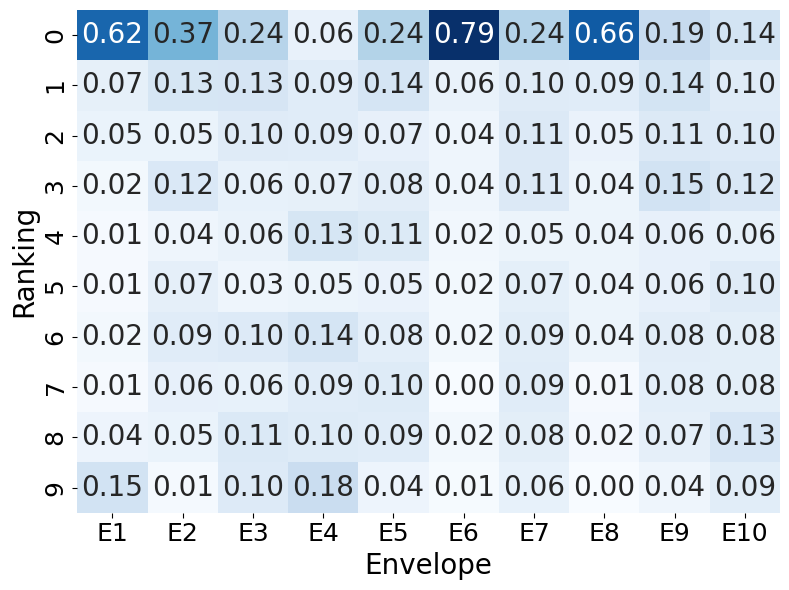

In [358]:
from collections import defaultdict
ranks = 9-np.argsort(np.argsort(np.array(explanations)[:, -10:], axis=1))

conf_matrix = []
for k in np.unique(targets):
    tmask = np.array(targets) == k
    
    d = defaultdict(lambda: 0)
    d.update({k:v for k, v in zip(*np.unique(ranks[np.where(tmask)][:,k], return_counts=True))})
    v = np.array([d[i] for i in range(10)])
    v = v / v.sum()
    conf_matrix.append(v)
    
conf_matrix = np.array(conf_matrix).T

# Define class labels (replace with your actual class names)
class_labels = [f"E{i}" for i in range(1, 11)]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='0.2f', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=range(10),
           annot_kws={"size": 20}, cbar=False)
plt.xlabel('Envelope', fontsize=20)
plt.ylabel('Ranking', fontsize=20)
#plt.title('Ranking envelop importance', fontsize = 30)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.tight_layout()
plt.savefig('fake_envelope_raking.pdf')